# Setup the PEST(++) interface around the modified Freyberg model

In this notebook, we will construct a complex model independent (non-intrusive) interface around an existing `MODFLOW6` model using `pyEMU`. We assume that the reader is at least partially familiar with PEST(++) file formats and working philosophy. 

The modified Freyberg groundwater flow model has been constructed and is described in a previous notebook from this series. We will construct the entire PEST(++) interface from scratch here. This setup will be built upon in subsequent tutorials. 

We will rely heavily on the `pyemu.PstFrom` class. Although here we employ it with a `MODFLOW6` model, `PstFrom` is designed to be general and software independent (mostly). Some features are only available for `MODFLOW` models (e.g. `SpatialReference`).

The `PstFrom` class automates the construction of high-dimensional PEST(++) interfaces with all the bells and whistles. It provides easy-to-use functions to process model input and output files into PEST(++) datasets. It can assist with setting up spatio-temporaly varying parameters. It handles the generation of geostatisical prior covariance matrices and ensembles. It automates writting a "model run" script. It provides tools to add custom pre- and post-processing functions to this script. It makes adding tweaks and fixes to the PEST(++) interface a breeze. All of this from the comfort of your favourite Python IDE.

During this tutorial we are going to construct a PEST dataset. Amongst other things, we will demonstrate:
 - how to add observations & parameters from model output & input files;
 - how to add pre- and post-processing functions to the "model run" script;
 - how to generate geostatistical structures for spatialy and temporally correlated parameters;
 - how to edit parameter/observation data sections;
 - how to generate a prior parameter covariance matrix and prior parameter ensemble;



First, let's get our model files and sort out some admin.


### 1. Admin & Organize Folders
First some admin. Load the dependencies and organize model folders. 

In [1]:
import sys
import os
import shutil
import platform
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pyemu
import flopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;

We will be calling a few external programs throughout this tutorial. Namely, MODFLOW 6 and PEST++GLM. For the purposes of the tutorial(s), we have included executables in the tutorial repository. They are in the `bin` folder. 

Preferably, executables should be located in a folder that is cited in your computer’s PATH environment variable. Doing so allows you to run them from a command prompt open to any other folder without having to include the full path to these executables in the command to run them. 

Sometimes this may not be practical. In such cases, we can simply place the executables in the folder from which they will be executed.  So, let's copy the necessary executables into our working folder:


In [2]:
# specify a temporary folder; we will gather all our model and executable files here first
# this is to ensure we don't mess up our original model files
tmp_d = os.path.join('freyberg_mf6')

# get the necessary executables; OS agnostic
bin_dir = os.path.join('..','..','bin')

if "window" in platform.platform().lower():
    exe_files = [f for f in os.listdir(bin_dir) if f.endswith('exe')]
else:
    exe_files = [f for f in os.listdir(bin_dir) if not f.endswith('exe')]

# remove existing folder if it already exists
if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)

# make the folder
os.mkdir(tmp_d)

# copy executables across
for exe_file in exe_files:
    shutil.copy2(os.path.join(bin_dir, exe_file),os.path.join(tmp_d,exe_file))

Let's copy the original model folder into a new working directory, just to ensure we don't mess up the base files.

In [3]:
# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'freyberg_mf6')

# copy files across to the temp folder
for f in os.listdir(org_d):
    shutil.copy2(os.path.join(org_d,f), os.path.join(tmp_d,f))

If you inspect the model folder, you will see that all the `MODFLOW6` model files have been written "externally". This is key for working with the `PstFrom` class (or with PEST(++) in general, really). Essentialy, all pertinent model inputs have been written as independent files in either array or list format. This makes it easier for us to programiatically access and re-write the values in these files.

Array files contain a data type (usually floating points). List files will have a few columns that contain index information and then columns of floating point values (they have a tabular format; think `.csv` files or DataFrames). The `PstFrom` class provides methods for processing these file types into a PEST(++) dataset. 



In [4]:
os.listdir(tmp_d)

['freyberg6.dis',
 'freyberg6.dis.grb',
 'freyberg6.dis_botm_layer1.txt',
 'freyberg6.dis_botm_layer2.txt',
 'freyberg6.dis_botm_layer3.txt',
 'freyberg6.dis_delc.txt',
 'freyberg6.dis_delr.txt',
 'freyberg6.dis_idomain_layer1.txt',
 'freyberg6.dis_idomain_layer2.txt',
 'freyberg6.dis_idomain_layer3.txt',
 'freyberg6.dis_top.txt',
 'freyberg6.ghb',
 'freyberg6.ghb_stress_period_data_1.txt',
 'freyberg6.ic',
 'freyberg6.ic_strt_layer1.txt',
 'freyberg6.ic_strt_layer2.txt',
 'freyberg6.ic_strt_layer3.txt',
 'freyberg6.ims',
 'freyberg6.lst',
 'freyberg6.nam',
 'freyberg6.npf',
 'freyberg6.npf_icelltype_layer1.txt',
 'freyberg6.npf_icelltype_layer2.txt',
 'freyberg6.npf_icelltype_layer3.txt',
 'freyberg6.npf_k33_layer1.txt',
 'freyberg6.npf_k33_layer2.txt',
 'freyberg6.npf_k33_layer3.txt',
 'freyberg6.npf_k_layer1.txt',
 'freyberg6.npf_k_layer2.txt',
 'freyberg6.npf_k_layer3.txt',
 'freyberg6.oc',
 'freyberg6.rch',
 'freyberg6.rch_recharge_1.txt',
 'freyberg6.rch_recharge_10.txt',
 'freyb

Now we need just a tiny bit of info about the spatial discretization of the model - this is needed to work out separation distances between parameters to build a geostatistical prior covariance matrix later.

Here we will load the flopy sim and model instance just to help us define some quantities later - flopy is ***not required*** to use the `PstFrom` class. ***Neither is MODFLOW***. However, at the time of writting, support for `SpatialReference` to spatially locate parameters is limited to MODLOW models.

Load the simulation. Run it once to make sure it works and to ***make sure that model output files are in the folder***. 

In [5]:
# load simulation
sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_d)
# load flow model
gwf = sim.get_model()

# run the model once to make sure it works
sim.run_simulation()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package oc...
    loading package wel...
    loading package rch...
    loading package ghb...
    loading package sfr...


    loading package obs...
  loading ims package freyberg6...
FloPy is using the following executable to run the model: C:\Program Files\MODFLOW\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.2 07/30/2021

   MODFLOW 6 compiled Jul 31 2021 14:57:11 with IFORT compiler (ver. 20.21.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 

    Solving:  Stress period:     2    Time step:     1
    Solving:  Stress period:     3    Time step:     1
    Solving:  Stress period:     4    Time step:     1
    Solving:  Stress period:     5    Time step:     1
    Solving:  Stress period:     6    Time step:     1
    Solving:  Stress period:     7    Time step:     1
    Solving:  Stress period:     8    Time step:     1
    Solving:  Stress period:     9    Time step:     1
    Solving:  Stress period:    10    Time step:     1
    Solving:  Stress period:    11    Time step:     1
    Solving:  Stress period:    12    Time step:     1
    Solving:  Stress period:    13    Time step:     1


    Solving:  Stress period:    14    Time step:     1
    Solving:  Stress period:    15    Time step:     1
    Solving:  Stress period:    16    Time step:     1
    Solving:  Stress period:    17    Time step:     1
    Solving:  Stress period:    18    Time step:     1
    Solving:  Stress period:    19    Time step:     1
    Solving:  Stress period:    20    Time step:     1
    Solving:  Stress period:    21    Time step:     1
    Solving:  Stress period:    22    Time step:     1
    Solving:  Stress period:    23    Time step:     1
    Solving:  Stress period:    24    Time step:     1
    Solving:  Stress period:    25    Time step:     1


 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/03/18 15:11:19
 Elapsed run time:  0.641 Seconds
 
 Normal termination of simulation.


(True, [])

### 2. Spatial Reference
Now we can instantiate a `SpatialReference`. This will later be passed to `PstFrom` to assist with spatially locating parameters (e.g. pilot points and/or cell-by-cell parameters).

In [6]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(tmp_d, "freyberg6.nam"),
        delr=gwf.dis.delr.array, delc=gwf.dis.delc.array)

   could not remove start_datetime


### 3. Instantiate PstFrom

Now we can start to construct the PEST(++) interface by instantiating a `PstFrom` class instance. There are a few things that we need to specify up front:

 - the folder in which we currently have model files (e.g. `tmp_d`). PstFrom will copy all the files from this directory into a new "template" folder.
 - **template folder**: this is a folder in which the PEST dataset will be constructed. This folder/dataset will form the template for subsequent deployment of PEST(++). It is **not** where PEST(++) will be run.
 - **longnames**: for backwards compatibility with PEST and PEST_HP (i.e. non-PEST++ versions), which have upper limits to parameter/obsveration names (PEST++ does not). Setting this value to False is only recommended if required. 
 - Whether the model is `zero based` or not.
 - (optional) the **spatial reference**, as previously discussed. This is only requried if using `pyEMU` to define parameter spatial correlation. Alternatively, you can define these yourself or use utilities available in the PEST-suite. 



In [7]:
# specify a template directory (i.e. the PstFrom working folder)
template_ws = os.path.join("freyberg6_template")

# instantiate PstFrom
pf = pyemu.utils.PstFrom(original_d=tmp_d, # where the model is stored
                            new_d=template_ws, # the PEST template folder
                            remove_existing=True, # ensures a clean start
                            longnames=True, # set False if using PEST/PEST_HP
                            spatial_reference=sr, #the spatial reference we generated earlier
                            zero_based=False, # does the MODEL use zero based indices? For example, MODFLOW does NOT
                            start_datetime="1-1-2018") # required when specifying temporal correlation between parameters

2022-03-18 15:11:19.866615 starting: opening PstFrom.log for logging
2022-03-18 15:11:19.867613 starting PstFrom process
2022-03-18 15:11:19.867613 starting: setting up dirs
2022-03-18 15:11:19.867613 starting: copying original_d 'freyberg_mf6' to new_d 'freyberg6_template'


2022-03-18 15:11:20.757503 finished: copying original_d 'freyberg_mf6' to new_d 'freyberg6_template' took: 0:00:00.889890
2022-03-18 15:11:20.758470 finished: setting up dirs took: 0:00:00.890857


### 4. Observations

We now have a `PstFrom` instance assigned to the variable `pf`. For now it is only an empty container to which we can start adding "observations", "parameters" and other bits and bobs.

Lets start with observations because they are easier. `MODFLOW6` makes life even easier by recording observations in nicely organized .csv files. Isn't that a peach!

#### 4.1 Freyberg Recap
As you may recall from the "*intro to Freyberg*" tutorial, the model is configured to record time series of head at observation wells, and flux at three locations along the river. These are recorded in external .csv files named `heads.csv` and `sfr.csv`, respectively. You should be able to see these files in the model folder.

Recall that each .csv houses records of observation time-series. Outputs are recorded for each simulated stress-period. The model starts with a single steady-state stress-period, followed by 24 monthly transient stress-periods. The steady-state and first 12 transient stress-periods simulate the history-matching period. The last 12 transient stress periods simulate future conditions (i.e. the prediction period).

In [8]:
# check the output csv file names
for i in gwf.obs:
    print(i.output.obs_names)

['sfr.csv']
['heads.csv']


Let's start with the 'heads.csv' file. First load it as a DataFrame to take a look.

As you can see, there are many columns, one for each observation site. Conveniently, * *cough* * they are named according to the cell layer, row and column. Note that at every site, there is an observation in both the top and bottom layer (0_ and 2_). We will make use of this later to create "secondary observations" of head differences between layers...but let's not get distracted.

The values in the *.csv* file were generated by running the model. (***IMPORTANT!***) However, `PstFrom` assumes that values in this file are the *target* observation values, and they will be used to populate the PEST(++) dataset. Now, you can change these values later on if you wish. However, it can get a bit messy. So you either need to populate model output files with the target values, or update values in the PEST(++) dataset later on. Which approach you adopt is up to personal preference and/or specifics of your modelling workflow. 

We will demonstrate both in this notebook.

In [9]:
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)
df.head()

,TRGW_2_2_15,TRGW_2_2_9,TRGW_2_3_8,TRGW_2_9_1,TRGW_2_13_10,TRGW_2_15_16,TRGW_2_21_10,TRGW_2_22_15,TRGW_2_24_4,TRGW_2_26_6,...,TRGW_0_9_1,TRGW_0_13_10,TRGW_0_15_16,TRGW_0_21_10,TRGW_0_22_15,TRGW_0_24_4,TRGW_0_26_6,TRGW_0_29_15,TRGW_0_33_7,TRGW_0_34_10
time,,,,,,,,,,,,,,,,,,,,,
1.0,34.339320,34.581597,34.611207,34.872171,34.257574,34.136387,34.144465,34.027679,34.310857,34.171589,...,34.878082,34.263187,34.141599,34.150067,33.992380,34.316575,34.177206,33.909874,33.985755,33.890192
32.0,34.422684,34.680896,34.712058,34.973141,34.381609,34.245718,34.272721,34.138233,34.437640,34.313791,...,34.978998,34.386488,34.250497,34.277455,34.087585,34.442526,34.318135,33.992787,34.102892,34.005675
61.0,34.496186,34.778508,34.812111,35.083708,34.481942,34.330460,34.376598,34.219319,34.555036,34.427653,...,35.089608,34.487850,34.336217,34.382375,34.158109,34.560492,34.433115,34.058266,34.196067,34.086361
92.0,34.541607,34.848735,34.885189,35.178103,34.536194,34.372437,34.431944,34.257802,34.631805,34.490964,...,35.184255,34.543248,34.379139,34.438943,34.191730,34.638273,34.497733,34.090937,34.244095,34.121186
122.0,34.538213,34.859840,34.898354,35.214761,34.520171,34.353363,34.414553,34.236799,34.634051,34.476152,...,35.221267,34.528011,34.360599,34.422425,34.173799,34.641451,34.483960,34.076498,34.226023,34.095425


#### 4.2 Prepare Observation Files

We will start by populating our "model output" file with measured values. For this synthetic case, we conveniently have observations for all model output times and sites. (These "measured" values were generated using the same model with a randomly generated set of parameters; noise was added to all observations.)

In the next cell we read a .csv that contains measured obsevration values. As it has the exact same structure as our model output file, we can simpy replace the values in the model output file (and re-write it!). In real-world cases this step will likley be a bit more involved.

In [10]:
# read the measured head values
hds_meas = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"heads.meas.csv"),
                    index_col=0)

# re-write the model output .csv file with the measured values
hds_meas.to_csv(os.path.join(template_ws,"heads.csv"))

#### 4.2. Adding Observations

Now that our model output file contains the "target values", we can use the `PstFrom.add_observations()` method to add observations to our `pf` object. This method reads ***list-type*** files. The assumption is that these files are organized in a tabular format. 

We are going to tell `pf` which columns of this file contain observations. Values in these columns will be assigned to *observation values*.

We can also inform it if there is an index column. Values in this column will be included in the *observation names*. 

We could also specify which rows to include as observations. But observations are free...so why not keep them all! 

Let's add observations from `heads.csv`. The first column of this file records the time at which the value is simulated. Let's use that as the index column (this becomes useful later on to post-process results). We want all other columns as observation values.


In [11]:
hds_df = pf.add_observations("heads.csv", # the model output file to read
                            insfile="heads.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hds") #prefix to all observation names; choose something logical and easy o find. We use it later on to select obsevrations

2022-03-18 15:11:20.812360 starting: adding observations from output file heads.csv
2022-03-18 15:11:20.813354 starting: adding observations from tabular output file '['heads.csv']'
2022-03-18 15:11:20.813354 starting: reading list-style file: freyberg6_template\heads.csv
2022-03-18 15:11:20.820302 finished: reading list-style file: freyberg6_template\heads.csv took: 0:00:00.006948
2022-03-18 15:11:20.820302 starting: building insfile for tabular output file heads.csv
2022-03-18 15:11:20.829311 finished: building insfile for tabular output file heads.csv took: 0:00:00.009009
2022-03-18 15:11:20.830310 starting: adding observation from instruction file 'freyberg6_template\heads.csv.ins'
2022-03-18 15:11:20.849284 finished: adding observation from instruction file 'freyberg6_template\heads.csv.ins' took: 0:00:00.018974
2022-03-18 15:11:20.850257 finished: adding observations from tabular output file '['heads.csv']' took: 0:00:00.036903


Let's inspect what we just created. 

We can see that the `.add_observations()` method returned a dataframe with lots of useful info: 

 - the observation names that were formed (see `obsnme` column); note that these inlcude lots of usefull metadata like the column name, index value and so on;
 - the values that were read from `heads.csv` (see `obsval` column); 
 - some generic weights and group names; note that observations are grouped according to the column of the model output .csv. Alternatively, we could have specified a list of observation group names.

In [12]:
hds_df.head()

,obsnme,obsval,weight,obgnme
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450661,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441799,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375622,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323056,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10


At this point, no PEST *control file* has been created, we have simply prepared to add these observations to the control file later. Everything is still only stored in memory. However, a PEST *instruction* file has been created in the template folder (`template_ws`):

In [13]:
[f for f in os.listdir(template_ws) if f.endswith(".ins")]

['heads.csv.ins']

Blimey, wasn't that easy? Automatically assimilating thousands of observations into a PEST dataset becomes a breeze!

Let's quickly do the same thing for the SFR observations.

In [14]:
df = pd.read_csv(os.path.join(template_ws, "sfr.csv"), index_col=0)
df.head()

,HEADWATER,TAILWATER,GAGE_1
time,,,
1.0,-644.10,-477.76,1205.3
32.0,-865.29,-638.26,1636.6
61.0,-1034.00,-764.91,1938.5
92.0,-1118.70,-825.49,2073.6
122.0,-1083.00,-794.89,1983.4


In [15]:
# read the measured  values
meas = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"sfr.meas.csv"),
                    index_col=0)
# re-write the model output .csv file with the measured values
meas.to_csv(os.path.join(template_ws,"sfr.csv"))
# add the observations to pf
sfr_df = pf.add_observations("sfr.csv", # the model output file to read
                            insfile="sfr.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="sfr") #prefix to all observation names

2022-03-18 15:11:20.896168 starting: adding observations from output file sfr.csv
2022-03-18 15:11:20.896168 starting: adding observations from tabular output file '['sfr.csv']'
2022-03-18 15:11:20.896168 starting: reading list-style file: freyberg6_template\sfr.csv
2022-03-18 15:11:20.898129 finished: reading list-style file: freyberg6_template\sfr.csv took: 0:00:00.001961
2022-03-18 15:11:20.898129 starting: building insfile for tabular output file sfr.csv
2022-03-18 15:11:20.906108 finished: building insfile for tabular output file sfr.csv took: 0:00:00.007979
2022-03-18 15:11:20.906108 starting: adding observation from instruction file 'freyberg6_template\sfr.csv.ins'
2022-03-18 15:11:20.915116 finished: adding observation from instruction file 'freyberg6_template\sfr.csv.ins' took: 0:00:00.009008
2022-03-18 15:11:20.916114 finished: adding observations from tabular output file '['sfr.csv']' took: 0:00:00.019946


### 5. Parameters

The `PstFrom.add_parameters()` method reads model input files and adds parameters to the PEST(++) dataset. Parameterisation can be configured in several ways. 

 - model input files can be in array or list format;
 - parameters can be setup as different "types". Values in model input files can (1) each be a separate parameter, (2) be grouped into "zones" or (3) all be treated as a single parameter. Alteratvely, (4) parameters can be assigned to pilot points, from which individual parameter values are subsequently interpolated. `PstFrom` adds the relevant pre-processing steps to assign paramter values directly into the "model run" script.
 - parameter values can be setup as "direct", "multiplier" or "addend". This means the "parameter value" which PEST(++) sees can be (1) the same value the model sees, (2) a multiplier on the value in the model input file, or (3) a value which is added to the value in the model input file. This is very nifty. `PstFrom` is designed to preferentially use parameters setup as multipliers. These let us preserve the existing model inputs and treat them as the mean of the prior parameter distribution. Once again, relevant pre-processing scripts are automatically added to the "model run" script (discussed later).


#### 5.1. Freyberg Recap

As discussed, all model inputs are stored in external files. Some are arrays. Others are lists. Recall that our model has 3 layers. It is transient. Hydraulic properties (Kh, Kv, Ss, Sy) vary in space. Recharge varies over both space and time. We have GHBs, SFR and WEL boundary conditions. GHB parameters are constant over time, but vary spatially. SFR inflow varies over time. Pumping rates of individual wells are uncertain in space and and time.

All of these have some degree of spatial and/or temporal correlation.

#### 5.2. Geostatistical Structures

Parameter correlation plays a role in (1) regularization when giving preference to the emergence of patterns of spatial heterogeneity and (2) when specifying the prior parameter probability distribution. Since we are all sophisticated and recognize the importance of expressing spatial and temporal uncertainty (e.g. heterogeneity) in the model inputs (and the corresponding spatial correlation in those uncertain inputs), let's use geostatistics to express uncertainty. To do that we need to define "geostatistical structures". 

For the sake of this tutorial, let's assume that heterogeneity in all spatially distributed parameters share the same statistical characteristics. Likewise for temporally varying parameters. We will therefore only  construct two geostatisitcal structures.

<AxesSubplot:xlabel='distance', ylabel='$\\gamma$'>

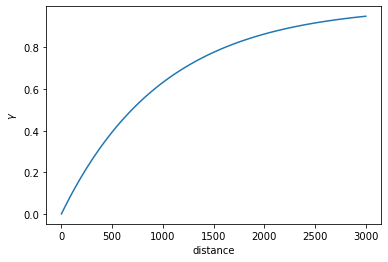

In [16]:
# exponential variogram for spatially varying parameters
v_space = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=1000, # range of correlation; length units of the model. In our case 'meters'
                                    anisotropy=1.0, #name says it all
                                    bearing=0.0 #angle in degrees East of North corresponding to anisotropy ellipse
                                    )

# geostatistical structure for spatially varying parameters
grid_gs = pyemu.geostats.GeoStruct(variograms=v_space, transform='log') 

# plot the gs if you like:
grid_gs.plot()

In [17]:
# exponential variogram for time varying parameters
v_time = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=60, # range of correlation; length time units (days)
                                    anisotropy=1.0, #do not change for 1-D time
                                    bearing=0.0 #do not change for 1-D time
                                    )

# geostatistical structure for time varying parameters
temporal_gs = pyemu.geostats.GeoStruct(variograms=v_time, transform='none') 

#### 5.3. Add Parameters

Let's start by adding parameters of hydraulic properties that vary in space (but not time) and which are housed in array-type files (e.g. Kh, Kv, Ss, Sy). We will start by demonstrating step-by-step for Kh.

First, find all the external array files that contain Kh values. In our case, these are the files with "npf_k_" in the file name. As you can see below, there is one file for each model layer. 

In [18]:
tag = "npf_k_"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg6.npf_k_layer1.txt', 'freyberg6.npf_k_layer2.txt', 'freyberg6.npf_k_layer3.txt']


Let's setup multiple spatial scales of parameters for Kh. To do this we will use three of the parameter "types" described above. The coarse scale will be a `constant` single value for each array. The medium scale will `pilot points`. The finest scale will use parameters as the `grid` scale (a unique parameter for each model cell!)

Each scale of parameters will work with the others as multipliers with the existing Kh arrays. (This all happens at runtime as part of the "model run" script.) Think of the scales as dials that PEST(++) can turn to improve the fit. The "coarse" scale is one big dial that alows PEST to move everything at once. The "medium" dials are few (but not too many) that allow PEST to adjust broad areas, but not making eveything move. The "fine" scales are lots of small dials that allow PEST(++) to have very detailed control, tweaking parameter values within very small areas. 

However, because we are working with parameter `multipliers`, we will need to specify two sets of parameter bounds: 
 - `upper_bound` and `lower_bound` are the standard control file bounds, while
 - `ult_ubound` and `ult_lbound` are bounds that are applied at runtime to the resulting (multiplied out) model input array. 
 
Since we are using sets of multipliers, it is important to make sure we keep the resulting model input arrays within the range of realistic values.

#### 5.3.1. Array Files

We will first demonstrate steb-by-step for `freyberg6.npf_k_layer1.txt`. We will start with grid scale parameters. These are multipliers assigned to each individual value in the array.

We start by getting the idomain array. As our model has inactive cells, this heps us avoid adding unncessary parameters. It is also required later when generating pilot points.

In [19]:
# as IDOMIAN is the same in all layers, we can use any layer
ib = gwf.dis.idomain.get_data(layer=0)

In [20]:
f = 'freyberg6.npf_k_layer1.txt'

# grid (fine) scale parameters
df_gr = pf.add_parameters(f,
                zone_array=ib, #as we have inactie model cells, we can avoid assigning these as parameters
                par_type="grid", #specify the type, these will be unique parameters for each cell
                geostruct=grid_gs, # the gestatisical structure for spatial correlation 
                par_name_base=f.split('.')[1]+"_gr", #specify a parameter name base that allows us to easily identify the filename and parameter type. "_gr" for "grid", and so forth.
                pargp=f.split('.')[1]+"_gr", #likewise for the parameter group name
                lower_bound=0.2, upper_bound=5.0, #parameter lower and upper bound
                ult_ubound=100, ult_lbound=0.01 # The ultimate bounds for multiplied model input values. Here we are stating that, after accounting for all multipliers, Kh cannot exceed these values. Very important with multipliers
                )

2022-03-18 15:11:21.246688 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-18 15:11:21.246688 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-18 15:11:21.253669 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.006981
2022-03-18 15:11:21.253669 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-18 15:11:21.255664 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl'
2022-03-18 15:11:21.255664 starting: writing template file freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl for ['npf_k_layer1_gr_inst:0']
2022-03-18 15:11:21.268629 finished: writing template file freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl for ['npf_k_layer1_gr_inst:0'] took: 0:00:00.012965
2022-03-18 15:11:21.268629 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl'
2022-0

As when adding observations,  `pf.add_parameters()` returns a dataframe. Take a look. You may recognize alot of the information that appears in a PEST `*parameter data` section. All of this is still only housed in memory for now. We will write the PEST control file later on.

In [21]:
df_gr.head()

,parnme,parval1,i,j,x,y,pargp,tpl_filename,input_filename,partype,partrans,parubnd,parlbnd,parchglim,scale,offset,dercom
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,1.0,0,0,125.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,factor,1.0,0.0,1
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,1.0,0,1,375.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,factor,1.0,0.0,1
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,1.0,0,2,625.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,factor,1.0,0.0,1
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,1.0,0,3,875.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,factor,1.0,0.0,1
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,1.0,0,4,1125.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,factor,1.0,0.0,1


Now, we add pilot point (medium scale) multiplier parameters to the same model input file. These multipliers are assigned to pilot points, which are subsequently interpolated to values in the array.

You can add pilot points in two ways:

1. `PstFrom` can generate them for you on a regular grid or 
2. you can supply `PstFrom` with existing pilot point location information. 

When you change `par_type` to "pilotpoints", by default, a regular grid of pilot points is setup using a default `pp_space` value of 10 (which is every 10th row and column). You can chnge this spacing by passing a integer to `pp_space` (as demonstrated below). 

Alternatively you can specify a filename or dataframe with pilot point locations. If you supply `pp_space` as a `str` it is assumed to be a filename. The extension is the guide: ".csv" for dataframe, ".shp" for shapefile (point-type). Anything else and the file is assumed to be a pilot points file type. The dataframe (or .csv file) must have "name", "x", and "y" as columns - it can have more, but must have those. 

In [22]:
# pilot point (medium) scale parameters
df_pp = pf.add_parameters(f,
                    zone_array=ib,
                    par_type="pilotpoints",
                    geostruct=grid_gs,
                    par_name_base=f.split('.')[1]+"_pp",
                    pargp=f.split('.')[1]+"_pp",
                    lower_bound=0.2,upper_bound=5.0,
                    ult_ubound=100, ult_lbound=0.01,
                    pp_space=4) # `PstFrom` will generate a unifrom grid of pilot points in every 4th row and column

2022-03-18 15:11:21.302538 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-18 15:11:21.302538 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-18 15:11:21.304534 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.001996
2022-03-18 15:11:21.304534 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-18 15:11:21.306529 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_pp_inst0_pilotpoints.csv.tpl'
2022-03-18 15:11:21.306529 starting: setting up pilot point parameters
2022-03-18 15:11:21.306529 No spatial reference (containing cell spacing) passed.
2022-03-18 15:11:21.306529 OK - using spatial reference in parent object.


2022-03-18 15:11:21.443718 32 pilot point parameters created
2022-03-18 15:11:21.443718 pilot point 'pargp':npf_k_layer1_pp
2022-03-18 15:11:21.443718 finished: setting up pilot point parameters took: 0:00:00.137189
2022-03-18 15:11:21.450699 starting: calculating factors for pargp=npf_k_layer1_pp
2022-03-18 15:11:21.450699 saving krige variance file:freyberg6_template\npf_k_layer1_pp_inst0pp.var.dat
2022-03-18 15:11:21.450699 saving krige factors file:freyberg6_template\npf_k_layer1_pp_inst0pp.fac
starting interp point loop for 706 points


starting 0


starting 1


starting 2


starting 3


starting 4


starting 5


starting 6


starting 7


starting 8


starting 9


took 16.54739 seconds
2022-03-18 15:11:38.044027 finished: calculating factors for pargp=npf_k_layer1_pp took: 0:00:16.593328
2022-03-18 15:11:38.044027 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_pp_inst0pp.dat.tpl'
2022-03-18 15:11:38.044969 saving zone array freyberg6_template\npf_k_layer1_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k_layer1_pp_inst0pp.dat.tpl
2022-03-18 15:11:38.050017 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt'] took: 0:00:16.747479


Lastly, add the constant (coarse) parameter multiplier. This is a single multiplier value applied to all values in the array. 

In [23]:
# constant (coarse) scale parameters
df_cst = pf.add_parameters(f,
                    zone_array=ib,
                    par_type="constant",
                    geostruct=grid_gs,
                    par_name_base=f.split('.')[1]+"_cn",
                    pargp=f.split('.')[1]+"_cn",
                    lower_bound=0.2,upper_bound=5.0,
                    ult_ubound=100, ult_lbound=0.01)

2022-03-18 15:11:38.056964 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-18 15:11:38.056964 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-18 15:11:38.058957 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.001993
2022-03-18 15:11:38.058957 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-18 15:11:38.059958 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl'
2022-03-18 15:11:38.059958 starting: writing template file freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl for ['npf_k_layer1_cn_inst:0']
2022-03-18 15:11:38.066950 finished: writing template file freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl for ['npf_k_layer1_cn_inst:0'] took: 0:00:00.006992
2022-03-18 15:11:38.067907 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_cn_inst0_cons

Let's do that for Kh in the other layers. We are going to be doing this a few times, so lets write a function.

In [24]:
def add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100):
    # grid (fine) scale parameters
    pf.add_parameters(f,
                    zone_array=ib,
                    par_type="grid", #specify the type, these will be unique parameters for each cell
                    geostruct=grid_gs, # the gestatisical structure for spatial correlation 
                    par_name_base=f.split('.')[1]+"_gr", #specify a parameter name base that allows us to easily identify the filename and parameter type. "_gr" for "grid", and so forth.
                    pargp=f.split('.')[1]+"_gr", #likewise for the parameter group name
                    lower_bound=lb, upper_bound=ub, #parameter lower and upper bound
                    ult_ubound=uub, ult_lbound=ulb # The ultimate bounds for multiplied model input values. Here we are stating that, after accounting for all multipliers, Kh cannot exceed these values. Very important with multipliers
                    )
                    
    # pilot point (medium) scale parameters
    pf.add_parameters(f,
                        zone_array=ib,
                        par_type="pilotpoints",
                        geostruct=grid_gs,
                        par_name_base=f.split('.')[1]+"_pp",
                        pargp=f.split('.')[1]+"_pp",
                        lower_bound=lb, upper_bound=ub,
                        ult_ubound=uub, ult_lbound=ulb,
                        pp_space=4) # `PstFrom` will generate a unifrom grid of pilot points in every 4th row and column

    # constant (coarse) scale parameters
    pf.add_parameters(f,
                        zone_array=ib,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=f.split('.')[1]+"_cn",
                        pargp=f.split('.')[1]+"_cn",
                        lower_bound=lb, upper_bound=ub,
                        ult_ubound=uub, ult_lbound=ulb)
    return

In [25]:
for f in files[1:]:
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100)

2022-03-18 15:11:38.088878 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer2.txt']
2022-03-18 15:11:38.088878 starting: loading array freyberg6_template\freyberg6.npf_k_layer2.txt
2022-03-18 15:11:38.095877 finished: loading array freyberg6_template\freyberg6.npf_k_layer2.txt took: 0:00:00.006999
2022-03-18 15:11:38.095877 loaded array 'freyberg_mf6\freyberg6.npf_k_layer2.txt' of shape (40, 20)
2022-03-18 15:11:38.097872 starting: writing array-style template file 'freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl'
2022-03-18 15:11:38.097872 starting: writing template file freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl for ['npf_k_layer2_gr_inst:0']
2022-03-18 15:11:38.109847 finished: writing template file freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl for ['npf_k_layer2_gr_inst:0'] took: 0:00:00.011975
2022-03-18 15:11:38.110844 starting: writing array-based template file 'freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl'
2022-0

2022-03-18 15:11:38.190614 pilot point 'pargp':npf_k_layer2_pp
2022-03-18 15:11:38.190614 finished: setting up pilot point parameters took: 0:00:00.068803
2022-03-18 15:11:38.197562 starting: writing array-based template file 'freyberg6_template\npf_k_layer2_pp_inst0pp.dat.tpl'
2022-03-18 15:11:38.197562 saving zone array freyberg6_template\npf_k_layer2_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k_layer2_pp_inst0pp.dat.tpl
2022-03-18 15:11:38.232519 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer2.txt'] took: 0:00:00.114704
2022-03-18 15:11:38.233498 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer2.txt']
2022-03-18 15:11:38.233498 starting: loading array freyberg6_template\freyberg6.npf_k_layer2.txt
2022-03-18 15:11:38.234513 finished: loading array freyberg6_template\freyberg6.npf_k_layer2.txt took: 0:00:00.001015
2022-03-18 15:11:38.234513 loaded array 'freyberg_mf6\freyberg6.npf_k_layer2.txt'

2022-03-18 15:11:38.237489 starting: writing template file freyberg6_template\npf_k_layer2_cn_inst0_constant.csv.tpl for ['npf_k_layer2_cn_inst:0']
2022-03-18 15:11:38.244435 finished: writing template file freyberg6_template\npf_k_layer2_cn_inst0_constant.csv.tpl for ['npf_k_layer2_cn_inst:0'] took: 0:00:00.006946
2022-03-18 15:11:38.244435 starting: writing array-based template file 'freyberg6_template\npf_k_layer2_cn_inst0_constant.csv.tpl'
2022-03-18 15:11:38.244435 saving zone array freyberg6_template\npf_k_layer2_cn_inst0_constant.csv.zone for tpl file freyberg6_template\npf_k_layer2_cn_inst0_constant.csv.tpl
2022-03-18 15:11:38.250527 finished: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer2.txt'] took: 0:00:00.017029
2022-03-18 15:11:38.251526 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt']
2022-03-18 15:11:38.251526 starting: loading array freyberg6_template\freyberg6.npf_k_layer3.txt
2022-03-18 15:11:38.257

2022-03-18 15:11:38.273447 saving zone array freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.zone for tpl file freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl
2022-03-18 15:11:38.280428 finished: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt'] took: 0:00:00.028902
2022-03-18 15:11:38.280428 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt']
2022-03-18 15:11:38.280428 starting: loading array freyberg6_template\freyberg6.npf_k_layer3.txt
2022-03-18 15:11:38.282424 finished: loading array freyberg6_template\freyberg6.npf_k_layer3.txt took: 0:00:00.001996
2022-03-18 15:11:38.282424 loaded array 'freyberg_mf6\freyberg6.npf_k_layer3.txt' of shape (40, 20)
2022-03-18 15:11:38.283421 starting: writing array-style template file 'freyberg6_template\npf_k_layer3_pp_inst0_pilotpoints.csv.tpl'
2022-03-18 15:11:38.284385 starting: setting up pilot point parameters
2022-03-18 15:11:38.284385 No spatial reference (cont

2022-03-18 15:11:38.378694 saving zone array freyberg6_template\npf_k_layer3_cn_inst0_constant.csv.zone for tpl file freyberg6_template\npf_k_layer3_cn_inst0_constant.csv.tpl
2022-03-18 15:11:38.384713 finished: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt'] took: 0:00:00.017987


Well...hot damn, wasn't that easy? Let's speed through the other array parameter files.

In [26]:
# for Kv
tag = "npf_k33"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files:
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100)

# for Ss
tag = "sto_ss"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
# only for layer 2 and 3; we aren't monsters
for f in files[1:]: 
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=1e-6, uub=1e-3)

# For Sy
tag = "sto_sy"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
# only for layer 1
f = files[0]
add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=0.4)


2022-03-18 15:11:38.395682 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt']
2022-03-18 15:11:38.395682 starting: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt
2022-03-18 15:11:38.402837 finished: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt took: 0:00:00.007155
2022-03-18 15:11:38.402837 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer1.txt' of shape (40, 20)
2022-03-18 15:11:38.404661 starting: writing array-style template file 'freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl'
2022-03-18 15:11:38.405623 starting: writing template file freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl for ['npf_k33_layer1_gr_inst:0']
2022-03-18 15:11:38.417642 finished: writing template file freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl for ['npf_k33_layer1_gr_inst:0'] took: 0:00:00.012019
2022-03-18 15:11:38.417642 starting: writing array-based template file 'freyberg6_template\npf_k33_layer1_gr_inst0_

2022-03-18 15:11:38.425568 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt']
2022-03-18 15:11:38.425568 starting: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt
2022-03-18 15:11:38.426566 finished: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt took: 0:00:00.000998
2022-03-18 15:11:38.426566 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer1.txt' of shape (40, 20)
2022-03-18 15:11:38.428560 starting: writing array-style template file 'freyberg6_template\npf_k33_layer1_pp_inst0_pilotpoints.csv.tpl'
2022-03-18 15:11:38.429558 starting: setting up pilot point parameters
2022-03-18 15:11:38.429558 No spatial reference (containing cell spacing) passed.
2022-03-18 15:11:38.429558 OK - using spatial reference in parent object.


2022-03-18 15:11:38.496371 32 pilot point parameters created
2022-03-18 15:11:38.497336 pilot point 'pargp':npf_k33_layer1_pp
2022-03-18 15:11:38.497336 finished: setting up pilot point parameters took: 0:00:00.067778
2022-03-18 15:11:38.504317 starting: writing array-based template file 'freyberg6_template\npf_k33_layer1_pp_inst0pp.dat.tpl'
2022-03-18 15:11:38.504317 saving zone array freyberg6_template\npf_k33_layer1_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k33_layer1_pp_inst0pp.dat.tpl
2022-03-18 15:11:38.509337 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt'] took: 0:00:00.083769
2022-03-18 15:11:38.510328 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt']
2022-03-18 15:11:38.510328 starting: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt
2022-03-18 15:11:38.511298 finished: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt took: 0:00:00.000970
2022

2022-03-18 15:11:38.637962 32 pilot point parameters created
2022-03-18 15:11:38.638958 pilot point 'pargp':npf_k33_layer2_pp
2022-03-18 15:11:38.638958 finished: setting up pilot point parameters took: 0:00:00.078790
2022-03-18 15:11:38.644941 starting: writing array-based template file 'freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.tpl'
2022-03-18 15:11:38.645939 saving zone array freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.tpl
2022-03-18 15:11:38.650925 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt'] took: 0:00:00.094747
2022-03-18 15:11:38.650925 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt']
2022-03-18 15:11:38.650925 starting: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt
2022-03-18 15:11:38.652920 finished: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt took: 0:00:00.001995
2022

2022-03-18 15:11:38.676856 starting: writing array-style template file 'freyberg6_template\npf_k33_layer3_gr_inst0_grid.csv.tpl'
2022-03-18 15:11:38.676856 starting: writing template file freyberg6_template\npf_k33_layer3_gr_inst0_grid.csv.tpl for ['npf_k33_layer3_gr_inst:0']
2022-03-18 15:11:38.688824 finished: writing template file freyberg6_template\npf_k33_layer3_gr_inst0_grid.csv.tpl for ['npf_k33_layer3_gr_inst:0'] took: 0:00:00.011968
2022-03-18 15:11:38.689821 starting: writing array-based template file 'freyberg6_template\npf_k33_layer3_gr_inst0_grid.csv.tpl'
2022-03-18 15:11:38.689821 saving zone array freyberg6_template\npf_k33_layer3_gr_inst0_grid.csv.zone for tpl file freyberg6_template\npf_k33_layer3_gr_inst0_grid.csv.tpl
2022-03-18 15:11:38.696803 finished: adding grid type m style parameters for file(s) ['freyberg6.npf_k33_layer3.txt'] took: 0:00:00.027926
2022-03-18 15:11:38.696803 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_lay

2022-03-18 15:11:38.828450 finished: adding grid type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt'] took: 0:00:00.027925
2022-03-18 15:11:38.828450 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt']
2022-03-18 15:11:38.828450 starting: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt
2022-03-18 15:11:38.830445 finished: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt took: 0:00:00.001995
2022-03-18 15:11:38.830445 loaded array 'freyberg_mf6\freyberg6.sto_ss_layer2.txt' of shape (40, 20)
2022-03-18 15:11:38.832440 starting: writing array-style template file 'freyberg6_template\sto_ss_layer2_pp_inst0_pilotpoints.csv.tpl'
2022-03-18 15:11:38.832440 starting: setting up pilot point parameters
2022-03-18 15:11:38.832440 No spatial reference (containing cell spacing) passed.
2022-03-18 15:11:38.832440 OK - using spatial reference in parent object.


2022-03-18 15:11:38.901256 32 pilot point parameters created
2022-03-18 15:11:38.901256 pilot point 'pargp':sto_ss_layer2_pp
2022-03-18 15:11:38.901256 finished: setting up pilot point parameters took: 0:00:00.068816
2022-03-18 15:11:38.908237 starting: writing array-based template file 'freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.tpl'
2022-03-18 15:11:38.909234 saving zone array freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.zone for tpl file freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.tpl
2022-03-18 15:11:38.914221 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt'] took: 0:00:00.085771
2022-03-18 15:11:38.914221 starting: adding constant type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt']
2022-03-18 15:11:38.914221 starting: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt
2022-03-18 15:11:38.915218 finished: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt took: 0:00:00.000997
2022-03-18 1

2022-03-18 15:11:39.031969 32 pilot point parameters created
2022-03-18 15:11:39.031969 pilot point 'pargp':sto_ss_layer3_pp
2022-03-18 15:11:39.031969 finished: setting up pilot point parameters took: 0:00:00.068879
2022-03-18 15:11:39.038950 starting: writing array-based template file 'freyberg6_template\sto_ss_layer3_pp_inst0pp.dat.tpl'
2022-03-18 15:11:39.038950 saving zone array freyberg6_template\sto_ss_layer3_pp_inst0pp.dat.zone for tpl file freyberg6_template\sto_ss_layer3_pp_inst0pp.dat.tpl
2022-03-18 15:11:39.044934 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_ss_layer3.txt'] took: 0:00:00.085833
2022-03-18 15:11:39.044934 starting: adding constant type m style parameters for file(s) ['freyberg6.sto_ss_layer3.txt']
2022-03-18 15:11:39.044934 starting: loading array freyberg6_template\freyberg6.sto_ss_layer3.txt
2022-03-18 15:11:39.046928 finished: loading array freyberg6_template\freyberg6.sto_ss_layer3.txt took: 0:00:00.001994
2022-03-18 1

2022-03-18 15:11:39.083830 saving zone array freyberg6_template\sto_sy_layer1_gr_inst0_grid.csv.zone for tpl file freyberg6_template\sto_sy_layer1_gr_inst0_grid.csv.tpl
2022-03-18 15:11:39.091809 finished: adding grid type m style parameters for file(s) ['freyberg6.sto_sy_layer1.txt'] took: 0:00:00.027926
2022-03-18 15:11:39.091809 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_sy_layer1.txt']
2022-03-18 15:11:39.091809 starting: loading array freyberg6_template\freyberg6.sto_sy_layer1.txt
2022-03-18 15:11:39.092806 finished: loading array freyberg6_template\freyberg6.sto_sy_layer1.txt took: 0:00:00.000997
2022-03-18 15:11:39.092806 loaded array 'freyberg_mf6\freyberg6.sto_sy_layer1.txt' of shape (40, 20)
2022-03-18 15:11:39.094800 starting: writing array-style template file 'freyberg6_template\sto_sy_layer1_pp_inst0_pilotpoints.csv.tpl'
2022-03-18 15:11:39.094800 starting: setting up pilot point parameters
2022-03-18 15:11:39.094800 No spatial referen

#### 5.3.2. Spatial and Temporal Correlation

Now, you may be thinking "shouldn't recharge have temporal correlation as well?". 

Damn straight it should. Now, this requires a little trickery.

First we need to construct a container of stress period datetimes. (This relies on specifying the start_datetime argument when instantiating `PstFrom`.) These datetime values will specify the postion of parameters on the time-axis.



In [27]:
# build up a container of stress period start datetimes - this will
# be used to specify the datetime of each multipler parameter
start_datetime="1-1-2018"
dts = pd.to_datetime(start_datetime) + pd.to_timedelta(np.cumsum(sim.tdis.perioddata.array["perlen"]),unit='d')

dts

DatetimeIndex(['2018-01-02', '2018-02-02', '2018-03-03', '2018-04-03',
               '2018-05-03', '2018-06-03', '2018-07-03', '2018-08-03',
               '2018-09-03', '2018-10-03', '2018-11-03', '2018-12-03',
               '2019-01-03', '2019-02-03', '2019-03-03', '2019-04-03',
               '2019-05-03', '2019-06-03', '2019-07-03', '2019-08-03',
               '2019-09-03', '2019-10-03', '2019-11-03', '2019-12-03',
               '2020-01-03'],
              dtype='datetime64[ns]', freq=None)

If you use the same parameter group name (`pargp`) and same geostruct, `PstFrom` will treat parameters setup across different calls to `add_parameters()` as correlated.  In this case, we want to express temporal correlation in the recharge multiplier parameters. So, we use the same parameter group names for each stress period data file, and specify the `datetime` and `geostruct` arguments.

Including temporal correlation introduces an additional challenge. Interpolation between points that share a common coordinate creates all types of trouble. We are going to have many parameters during each stress period (a single point on the time-axis). To get around this challenge we need to be a bit sneaky.


First, we will apply the multiple *spatial* scales of parameter multiplers (`constant`, `pilot point` and `grid`) as we did for hyraulic properties. 

Then, we will asign an additional `constant` multiplier parameter for each recharge stress-period file (so, a single multiplier for all recharge paramaters for each stress period). We will specify temporal correlation for these `constant` multipliers. These will all have the same parameter group name, as discussed above. 

In [28]:
# for Recharge; 
tag = "rch_recharge"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files:
    # the spatial multiplier parameters; just use the same function
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=2e-5, uub=2e-4)
    
    
    # multiplier that includes temporal correlation
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    
    # add the constant parameters (with temporal correlation)
    pf.add_parameters(filenames=f,
                    zone_array=ib,
                    par_type="constant",
                    par_name_base=f.split('.')[1]+"_tcn",
                    pargp=f.split('.')[1]+"_tcn",
                    lower_bound=0.5, upper_bound=1.5,
                    ult_ubound=2e-4, ult_lbound=2e-5,
                    datetime=dts[kper], # this places the parameter value on the "time axis"
                    geostruct=temporal_gs)

2022-03-18 15:11:39.213483 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt']
2022-03-18 15:11:39.214481 starting: loading array freyberg6_template\freyberg6.rch_recharge_1.txt
2022-03-18 15:11:39.219467 finished: loading array freyberg6_template\freyberg6.rch_recharge_1.txt took: 0:00:00.004986
2022-03-18 15:11:39.220464 loaded array 'freyberg_mf6\freyberg6.rch_recharge_1.txt' of shape (40, 20)
2022-03-18 15:11:39.221462 starting: writing array-style template file 'freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl'
2022-03-18 15:11:39.222459 starting: writing template file freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl for ['rch_recharge_1_gr_inst:0']


2022-03-18 15:11:39.235424 finished: writing template file freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl for ['rch_recharge_1_gr_inst:0'] took: 0:00:00.012965
2022-03-18 15:11:39.235424 starting: writing array-based template file 'freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl'
2022-03-18 15:11:39.235424 saving zone array freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl
2022-03-18 15:11:39.243403 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt'] took: 0:00:00.029920
2022-03-18 15:11:39.243403 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt']
2022-03-18 15:11:39.243403 starting: loading array freyberg6_template\freyberg6.rch_recharge_1.txt
2022-03-18 15:11:39.244400 finished: loading array freyberg6_template\freyberg6.rch_recharge_1.txt took: 0:00:00.000997
2022-03-18 15:11:39.244400 loaded array 'freyber

2022-03-18 15:11:39.316208 32 pilot point parameters created
2022-03-18 15:11:39.317207 pilot point 'pargp':rch_recharge_1_pp
2022-03-18 15:11:39.317207 finished: setting up pilot point parameters took: 0:00:00.070812
2022-03-18 15:11:39.324187 starting: writing array-based template file 'freyberg6_template\rch_recharge_1_pp_inst0pp.dat.tpl'
2022-03-18 15:11:39.324187 saving zone array freyberg6_template\rch_recharge_1_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_1_pp_inst0pp.dat.tpl
2022-03-18 15:11:39.329174 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt'] took: 0:00:00.085771
2022-03-18 15:11:39.329174 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt']
2022-03-18 15:11:39.329174 starting: loading array freyberg6_template\freyberg6.rch_recharge_1.txt
2022-03-18 15:11:39.331168 finished: loading array freyberg6_template\freyberg6.rch_recharge_1.txt took: 0:00:00.001994
2022

2022-03-18 15:11:39.395995 finished: loading array freyberg6_template\freyberg6.rch_recharge_10.txt took: 0:00:00.001995
2022-03-18 15:11:39.395995 loaded array 'freyberg_mf6\freyberg6.rch_recharge_10.txt' of shape (40, 20)
2022-03-18 15:11:39.397989 starting: writing array-style template file 'freyberg6_template\rch_recharge_10_pp_inst0_pilotpoints.csv.tpl'
2022-03-18 15:11:39.397989 starting: setting up pilot point parameters
2022-03-18 15:11:39.397989 No spatial reference (containing cell spacing) passed.
2022-03-18 15:11:39.397989 OK - using spatial reference in parent object.


2022-03-18 15:11:39.470795 32 pilot point parameters created
2022-03-18 15:11:39.470795 pilot point 'pargp':rch_recharge_10_pp
2022-03-18 15:11:39.471793 finished: setting up pilot point parameters took: 0:00:00.073804
2022-03-18 15:11:39.477776 starting: writing array-based template file 'freyberg6_template\rch_recharge_10_pp_inst0pp.dat.tpl'
2022-03-18 15:11:39.478774 saving zone array freyberg6_template\rch_recharge_10_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_10_pp_inst0pp.dat.tpl
2022-03-18 15:11:39.483763 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_10.txt'] took: 0:00:00.089763
2022-03-18 15:11:39.483763 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_10.txt']
2022-03-18 15:11:39.483763 starting: loading array freyberg6_template\freyberg6.rch_recharge_10.txt
2022-03-18 15:11:39.484758 finished: loading array freyberg6_template\freyberg6.rch_recharge_10.txt took: 0:00:00.000

2022-03-18 15:11:39.505701 starting: writing array-style template file 'freyberg6_template\rch_recharge_10_tcn_inst0_constant.csv.tpl'
2022-03-18 15:11:39.505701 starting: writing template file freyberg6_template\rch_recharge_10_tcn_inst0_constant.csv.tpl for ['rch_recharge_10_tcn_inst:0']
2022-03-18 15:11:39.512683 finished: writing template file freyberg6_template\rch_recharge_10_tcn_inst0_constant.csv.tpl for ['rch_recharge_10_tcn_inst:0'] took: 0:00:00.006982
2022-03-18 15:11:39.512683 starting: writing array-based template file 'freyberg6_template\rch_recharge_10_tcn_inst0_constant.csv.tpl'
2022-03-18 15:11:39.513681 saving zone array freyberg6_template\rch_recharge_10_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_10_tcn_inst0_constant.csv.tpl
2022-03-18 15:11:39.520662 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_10.txt'] took: 0:00:00.019947
2022-03-18 15:11:39.520662 starting: adding grid type m style paramete

2022-03-18 15:11:39.629371 32 pilot point parameters created
2022-03-18 15:11:39.629371 pilot point 'pargp':rch_recharge_11_pp
2022-03-18 15:11:39.630369 finished: setting up pilot point parameters took: 0:00:00.075798
2022-03-18 15:11:39.637350 starting: writing array-based template file 'freyberg6_template\rch_recharge_11_pp_inst0pp.dat.tpl'
2022-03-18 15:11:39.637350 saving zone array freyberg6_template\rch_recharge_11_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_11_pp_inst0pp.dat.tpl
2022-03-18 15:11:39.642336 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt'] took: 0:00:00.091754
2022-03-18 15:11:39.642336 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt']
2022-03-18 15:11:39.642336 starting: loading array freyberg6_template\freyberg6.rch_recharge_11.txt


2022-03-18 15:11:39.644331 finished: loading array freyberg6_template\freyberg6.rch_recharge_11.txt took: 0:00:00.001995
2022-03-18 15:11:39.644331 loaded array 'freyberg_mf6\freyberg6.rch_recharge_11.txt' of shape (40, 20)
2022-03-18 15:11:39.646325 starting: writing array-style template file 'freyberg6_template\rch_recharge_11_cn_inst0_constant.csv.tpl'
2022-03-18 15:11:39.646325 starting: writing template file freyberg6_template\rch_recharge_11_cn_inst0_constant.csv.tpl for ['rch_recharge_11_cn_inst:0']
2022-03-18 15:11:39.653307 finished: writing template file freyberg6_template\rch_recharge_11_cn_inst0_constant.csv.tpl for ['rch_recharge_11_cn_inst:0'] took: 0:00:00.006982
2022-03-18 15:11:39.654304 starting: writing array-based template file 'freyberg6_template\rch_recharge_11_cn_inst0_constant.csv.tpl'
2022-03-18 15:11:39.654304 saving zone array freyberg6_template\rch_recharge_11_cn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_11_cn_inst0_constant.csv.tp

2022-03-18 15:11:39.709050 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt'] took: 0:00:00.028815
2022-03-18 15:11:39.709050 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt']
2022-03-18 15:11:39.709050 starting: loading array freyberg6_template\freyberg6.rch_recharge_12.txt
2022-03-18 15:11:39.711038 finished: loading array freyberg6_template\freyberg6.rch_recharge_12.txt took: 0:00:00.001988
2022-03-18 15:11:39.711038 loaded array 'freyberg_mf6\freyberg6.rch_recharge_12.txt' of shape (40, 20)
2022-03-18 15:11:39.713035 starting: writing array-style template file 'freyberg6_template\rch_recharge_12_pp_inst0_pilotpoints.csv.tpl'
2022-03-18 15:11:39.713035 starting: setting up pilot point parameters
2022-03-18 15:11:39.713035 No spatial reference (containing cell spacing) passed.
2022-03-18 15:11:39.713035 OK - using spatial reference in parent object.
2022-03-18 15:11:39.783419 32 pilot point para

2022-03-18 15:11:39.817265 starting: writing array-style template file 'freyberg6_template\rch_recharge_12_tcn_inst0_constant.csv.tpl'
2022-03-18 15:11:39.817265 starting: writing template file freyberg6_template\rch_recharge_12_tcn_inst0_constant.csv.tpl for ['rch_recharge_12_tcn_inst:0']
2022-03-18 15:11:39.824300 finished: writing template file freyberg6_template\rch_recharge_12_tcn_inst0_constant.csv.tpl for ['rch_recharge_12_tcn_inst:0'] took: 0:00:00.007035
2022-03-18 15:11:39.825271 starting: writing array-based template file 'freyberg6_template\rch_recharge_12_tcn_inst0_constant.csv.tpl'
2022-03-18 15:11:39.825271 saving zone array freyberg6_template\rch_recharge_12_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_12_tcn_inst0_constant.csv.tpl
2022-03-18 15:11:39.833255 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt'] took: 0:00:00.019926
2022-03-18 15:11:39.833255 starting: adding grid type m style paramete

2022-03-18 15:11:39.839260 finished: loading array freyberg6_template\freyberg6.rch_recharge_13.txt took: 0:00:00.006005
2022-03-18 15:11:39.839260 loaded array 'freyberg_mf6\freyberg6.rch_recharge_13.txt' of shape (40, 20)
2022-03-18 15:11:39.842199 starting: writing array-style template file 'freyberg6_template\rch_recharge_13_gr_inst0_grid.csv.tpl'
2022-03-18 15:11:39.842199 starting: writing template file freyberg6_template\rch_recharge_13_gr_inst0_grid.csv.tpl for ['rch_recharge_13_gr_inst:0']
2022-03-18 15:11:39.855166 finished: writing template file freyberg6_template\rch_recharge_13_gr_inst0_grid.csv.tpl for ['rch_recharge_13_gr_inst:0'] took: 0:00:00.012967
2022-03-18 15:11:39.855166 starting: writing array-based template file 'freyberg6_template\rch_recharge_13_gr_inst0_grid.csv.tpl'
2022-03-18 15:11:39.856162 saving zone array freyberg6_template\rch_recharge_13_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_13_gr_inst0_grid.csv.tpl
2022-03-18 15:11:39.86

2022-03-18 15:11:39.939989 32 pilot point parameters created
2022-03-18 15:11:39.939989 pilot point 'pargp':rch_recharge_13_pp
2022-03-18 15:11:39.939989 finished: setting up pilot point parameters took: 0:00:00.073803
2022-03-18 15:11:39.946975 starting: writing array-based template file 'freyberg6_template\rch_recharge_13_pp_inst0pp.dat.tpl'
2022-03-18 15:11:39.947918 saving zone array freyberg6_template\rch_recharge_13_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_13_pp_inst0pp.dat.tpl
2022-03-18 15:11:39.952904 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_13.txt'] took: 0:00:00.089710
2022-03-18 15:11:39.952904 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_13.txt']
2022-03-18 15:11:39.953900 starting: loading array freyberg6_template\freyberg6.rch_recharge_13.txt
2022-03-18 15:11:39.954898 finished: loading array freyberg6_template\freyberg6.rch_recharge_13.txt took: 0:00:00.000

2022-03-18 15:11:40.011746 saving zone array freyberg6_template\rch_recharge_14_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_14_gr_inst0_grid.csv.tpl
2022-03-18 15:11:40.018727 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_14.txt'] took: 0:00:00.027869
2022-03-18 15:11:40.019761 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_14.txt']


2022-03-18 15:11:40.019761 starting: loading array freyberg6_template\freyberg6.rch_recharge_14.txt
2022-03-18 15:11:40.021721 finished: loading array freyberg6_template\freyberg6.rch_recharge_14.txt took: 0:00:00.001960
2022-03-18 15:11:40.021721 loaded array 'freyberg_mf6\freyberg6.rch_recharge_14.txt' of shape (40, 20)
2022-03-18 15:11:40.022759 starting: writing array-style template file 'freyberg6_template\rch_recharge_14_pp_inst0_pilotpoints.csv.tpl'
2022-03-18 15:11:40.022759 starting: setting up pilot point parameters
2022-03-18 15:11:40.022759 No spatial reference (containing cell spacing) passed.
2022-03-18 15:11:40.022759 OK - using spatial reference in parent object.
2022-03-18 15:11:40.090534 32 pilot point parameters created
2022-03-18 15:11:40.090534 pilot point 'pargp':rch_recharge_14_pp
2022-03-18 15:11:40.091584 finished: setting up pilot point parameters took: 0:00:00.068825
2022-03-18 15:11:40.097567 starting: writing array-based template file 'freyberg6_template\rc

2022-03-18 15:11:40.132424 saving zone array freyberg6_template\rch_recharge_14_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_14_tcn_inst0_constant.csv.tpl
2022-03-18 15:11:40.140453 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_14.txt'] took: 0:00:00.018948
2022-03-18 15:11:40.140453 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_15.txt']
2022-03-18 15:11:40.140453 starting: loading array freyberg6_template\freyberg6.rch_recharge_15.txt
2022-03-18 15:11:40.145439 finished: loading array freyberg6_template\freyberg6.rch_recharge_15.txt took: 0:00:00.004986
2022-03-18 15:11:40.145439 loaded array 'freyberg_mf6\freyberg6.rch_recharge_15.txt' of shape (40, 20)
2022-03-18 15:11:40.148432 starting: writing array-style template file 'freyberg6_template\rch_recharge_15_gr_inst0_grid.csv.tpl'
2022-03-18 15:11:40.148432 starting: writing template file freyberg6_template\rch_recharge_15_gr_ins

2022-03-18 15:11:40.244175 32 pilot point parameters created
2022-03-18 15:11:40.244175 pilot point 'pargp':rch_recharge_15_pp
2022-03-18 15:11:40.244175 finished: setting up pilot point parameters took: 0:00:00.071808
2022-03-18 15:11:40.251158 starting: writing array-based template file 'freyberg6_template\rch_recharge_15_pp_inst0pp.dat.tpl'
2022-03-18 15:11:40.251158 saving zone array freyberg6_template\rch_recharge_15_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_15_pp_inst0pp.dat.tpl
2022-03-18 15:11:40.257141 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_15.txt'] took: 0:00:00.088812
2022-03-18 15:11:40.257141 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_15.txt']
2022-03-18 15:11:40.257141 starting: loading array freyberg6_template\freyberg6.rch_recharge_15.txt
2022-03-18 15:11:40.259085 finished: loading array freyberg6_template\freyberg6.rch_recharge_15.txt took: 0:00:00.001

2022-03-18 15:11:40.314986 saving zone array freyberg6_template\rch_recharge_16_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_16_gr_inst0_grid.csv.tpl
2022-03-18 15:11:40.322914 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_16.txt'] took: 0:00:00.027926
2022-03-18 15:11:40.322914 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_16.txt']
2022-03-18 15:11:40.323910 starting: loading array freyberg6_template\freyberg6.rch_recharge_16.txt
2022-03-18 15:11:40.324953 finished: loading array freyberg6_template\freyberg6.rch_recharge_16.txt took: 0:00:00.001043
2022-03-18 15:11:40.324953 loaded array 'freyberg_mf6\freyberg6.rch_recharge_16.txt' of shape (40, 20)
2022-03-18 15:11:40.326947 starting: writing array-style template file 'freyberg6_template\rch_recharge_16_pp_inst0_pilotpoints.csv.tpl'
2022-03-18 15:11:40.326947 starting: setting up pilot point parameters
2022-03-18 15:11:40.326947 No

2022-03-18 15:11:40.429683 finished: loading array freyberg6_template\freyberg6.rch_recharge_16.txt took: 0:00:00.002017
2022-03-18 15:11:40.429683 loaded array 'freyberg_mf6\freyberg6.rch_recharge_16.txt' of shape (40, 20)
2022-03-18 15:11:40.431675 starting: writing array-style template file 'freyberg6_template\rch_recharge_16_tcn_inst0_constant.csv.tpl'
2022-03-18 15:11:40.431675 starting: writing template file freyberg6_template\rch_recharge_16_tcn_inst0_constant.csv.tpl for ['rch_recharge_16_tcn_inst:0']
2022-03-18 15:11:40.439653 finished: writing template file freyberg6_template\rch_recharge_16_tcn_inst0_constant.csv.tpl for ['rch_recharge_16_tcn_inst:0'] took: 0:00:00.007978
2022-03-18 15:11:40.440650 starting: writing array-based template file 'freyberg6_template\rch_recharge_16_tcn_inst0_constant.csv.tpl'
2022-03-18 15:11:40.440650 saving zone array freyberg6_template\rch_recharge_16_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_16_tcn_inst0_constan

2022-03-18 15:11:40.555343 32 pilot point parameters created
2022-03-18 15:11:40.555343 pilot point 'pargp':rch_recharge_17_pp
2022-03-18 15:11:40.555343 finished: setting up pilot point parameters took: 0:00:00.069862
2022-03-18 15:11:40.561332 starting: writing array-based template file 'freyberg6_template\rch_recharge_17_pp_inst0pp.dat.tpl'
2022-03-18 15:11:40.562326 saving zone array freyberg6_template\rch_recharge_17_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_17_pp_inst0pp.dat.tpl
2022-03-18 15:11:40.567312 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_17.txt'] took: 0:00:00.085790
2022-03-18 15:11:40.567312 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_17.txt']
2022-03-18 15:11:40.567312 starting: loading array freyberg6_template\freyberg6.rch_recharge_17.txt
2022-03-18 15:11:40.569338 finished: loading array freyberg6_template\freyberg6.rch_recharge_17.txt took: 0:00:00.002

2022-03-18 15:11:40.626154 finished: writing template file freyberg6_template\rch_recharge_18_gr_inst0_grid.csv.tpl for ['rch_recharge_18_gr_inst:0'] took: 0:00:00.013963
2022-03-18 15:11:40.626154 starting: writing array-based template file 'freyberg6_template\rch_recharge_18_gr_inst0_grid.csv.tpl'
2022-03-18 15:11:40.626154 saving zone array freyberg6_template\rch_recharge_18_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_18_gr_inst0_grid.csv.tpl
2022-03-18 15:11:40.633140 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt'] took: 0:00:00.028928
2022-03-18 15:11:40.633140 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt']
2022-03-18 15:11:40.633140 starting: loading array freyberg6_template\freyberg6.rch_recharge_18.txt
2022-03-18 15:11:40.634116 finished: loading array freyberg6_template\freyberg6.rch_recharge_18.txt took: 0:00:00.000976
2022-03-18 15:11:40.635079 loaded array

2022-03-18 15:11:40.738801 starting: writing array-style template file 'freyberg6_template\rch_recharge_18_tcn_inst0_constant.csv.tpl'
2022-03-18 15:11:40.738801 starting: writing template file freyberg6_template\rch_recharge_18_tcn_inst0_constant.csv.tpl for ['rch_recharge_18_tcn_inst:0']
2022-03-18 15:11:40.745783 finished: writing template file freyberg6_template\rch_recharge_18_tcn_inst0_constant.csv.tpl for ['rch_recharge_18_tcn_inst:0'] took: 0:00:00.006982
2022-03-18 15:11:40.745783 starting: writing array-based template file 'freyberg6_template\rch_recharge_18_tcn_inst0_constant.csv.tpl'
2022-03-18 15:11:40.746779 saving zone array freyberg6_template\rch_recharge_18_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_18_tcn_inst0_constant.csv.tpl
2022-03-18 15:11:40.754812 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt'] took: 0:00:00.019949
2022-03-18 15:11:40.754812 starting: adding grid type m style paramete

2022-03-18 15:11:40.861525 32 pilot point parameters created
2022-03-18 15:11:40.861525 pilot point 'pargp':rch_recharge_19_pp
2022-03-18 15:11:40.861525 finished: setting up pilot point parameters took: 0:00:00.074850
2022-03-18 15:11:40.869509 starting: writing array-based template file 'freyberg6_template\rch_recharge_19_pp_inst0pp.dat.tpl'
2022-03-18 15:11:40.869509 saving zone array freyberg6_template\rch_recharge_19_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_19_pp_inst0pp.dat.tpl
2022-03-18 15:11:40.874548 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_19.txt'] took: 0:00:00.091830
2022-03-18 15:11:40.874548 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_19.txt']
2022-03-18 15:11:40.874548 starting: loading array freyberg6_template\freyberg6.rch_recharge_19.txt
2022-03-18 15:11:40.876539 finished: loading array freyberg6_template\freyberg6.rch_recharge_19.txt took: 0:00:00.001

2022-03-18 15:11:40.931341 saving zone array freyberg6_template\rch_recharge_2_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_2_gr_inst0_grid.csv.tpl
2022-03-18 15:11:40.939354 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_2.txt'] took: 0:00:00.027959
2022-03-18 15:11:40.939354 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_2.txt']
2022-03-18 15:11:40.939354 starting: loading array freyberg6_template\freyberg6.rch_recharge_2.txt
2022-03-18 15:11:40.941348 finished: loading array freyberg6_template\freyberg6.rch_recharge_2.txt took: 0:00:00.001994
2022-03-18 15:11:40.941348 loaded array 'freyberg_mf6\freyberg6.rch_recharge_2.txt' of shape (40, 20)
2022-03-18 15:11:40.943353 starting: writing array-style template file 'freyberg6_template\rch_recharge_2_pp_inst0_pilotpoints.csv.tpl'
2022-03-18 15:11:40.943353 starting: setting up pilot point parameters
2022-03-18 15:11:40.943353 No spatial

2022-03-18 15:11:41.036063 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_2.txt']
2022-03-18 15:11:41.036063 starting: loading array freyberg6_template\freyberg6.rch_recharge_2.txt
2022-03-18 15:11:41.037059 finished: loading array freyberg6_template\freyberg6.rch_recharge_2.txt took: 0:00:00.000996
2022-03-18 15:11:41.037059 loaded array 'freyberg_mf6\freyberg6.rch_recharge_2.txt' of shape (40, 20)
2022-03-18 15:11:41.039108 starting: writing array-style template file 'freyberg6_template\rch_recharge_2_cn_inst0_constant.csv.tpl'
2022-03-18 15:11:41.039108 starting: writing template file freyberg6_template\rch_recharge_2_cn_inst0_constant.csv.tpl for ['rch_recharge_2_cn_inst:0']
2022-03-18 15:11:41.047087 finished: writing template file freyberg6_template\rch_recharge_2_cn_inst0_constant.csv.tpl for ['rch_recharge_2_cn_inst:0'] took: 0:00:00.007979
2022-03-18 15:11:41.047087 starting: writing array-based template file 'freyberg6_template\rch_rech

2022-03-18 15:11:41.174724 32 pilot point parameters created
2022-03-18 15:11:41.175741 pilot point 'pargp':rch_recharge_20_pp
2022-03-18 15:11:41.175741 finished: setting up pilot point parameters took: 0:00:00.069812
2022-03-18 15:11:41.181706 starting: writing array-based template file 'freyberg6_template\rch_recharge_20_pp_inst0pp.dat.tpl'
2022-03-18 15:11:41.182701 saving zone array freyberg6_template\rch_recharge_20_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_20_pp_inst0pp.dat.tpl
2022-03-18 15:11:41.187696 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_20.txt'] took: 0:00:00.085756
2022-03-18 15:11:41.187696 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_20.txt']
2022-03-18 15:11:41.188686 starting: loading array freyberg6_template\freyberg6.rch_recharge_20.txt
2022-03-18 15:11:41.189686 finished: loading array freyberg6_template\freyberg6.rch_recharge_20.txt took: 0:00:00.001

2022-03-18 15:11:41.226593 starting: loading array freyberg6_template\freyberg6.rch_recharge_21.txt
2022-03-18 15:11:41.232592 finished: loading array freyberg6_template\freyberg6.rch_recharge_21.txt took: 0:00:00.005999
2022-03-18 15:11:41.232592 loaded array 'freyberg_mf6\freyberg6.rch_recharge_21.txt' of shape (40, 20)
2022-03-18 15:11:41.234582 starting: writing array-style template file 'freyberg6_template\rch_recharge_21_gr_inst0_grid.csv.tpl'
2022-03-18 15:11:41.234582 starting: writing template file freyberg6_template\rch_recharge_21_gr_inst0_grid.csv.tpl for ['rch_recharge_21_gr_inst:0']
2022-03-18 15:11:41.247557 finished: writing template file freyberg6_template\rch_recharge_21_gr_inst0_grid.csv.tpl for ['rch_recharge_21_gr_inst:0'] took: 0:00:00.012975
2022-03-18 15:11:41.248494 starting: writing array-based template file 'freyberg6_template\rch_recharge_21_gr_inst0_grid.csv.tpl'
2022-03-18 15:11:41.248494 saving zone array freyberg6_template\rch_recharge_21_gr_inst0_grid.c

2022-03-18 15:11:41.377204 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_21.txt'] took: 0:00:00.019004
2022-03-18 15:11:41.377204 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_22.txt']
2022-03-18 15:11:41.377204 starting: loading array freyberg6_template\freyberg6.rch_recharge_22.txt
2022-03-18 15:11:41.383188 finished: loading array freyberg6_template\freyberg6.rch_recharge_22.txt took: 0:00:00.005984
2022-03-18 15:11:41.383188 loaded array 'freyberg_mf6\freyberg6.rch_recharge_22.txt' of shape (40, 20)
2022-03-18 15:11:41.385127 starting: writing array-style template file 'freyberg6_template\rch_recharge_22_gr_inst0_grid.csv.tpl'
2022-03-18 15:11:41.385127 starting: writing template file freyberg6_template\rch_recharge_22_gr_inst0_grid.csv.tpl for ['rch_recharge_22_gr_inst:0']
2022-03-18 15:11:41.399192 finished: writing template file freyberg6_template\rch_recharge_22_gr_inst0_grid.csv.tpl for ['rch_recharg

2022-03-18 15:11:41.411162 starting: writing array-style template file 'freyberg6_template\rch_recharge_22_pp_inst0_pilotpoints.csv.tpl'
2022-03-18 15:11:41.411162 starting: setting up pilot point parameters
2022-03-18 15:11:41.411162 No spatial reference (containing cell spacing) passed.
2022-03-18 15:11:41.411162 OK - using spatial reference in parent object.
2022-03-18 15:11:41.479943 32 pilot point parameters created
2022-03-18 15:11:41.480941 pilot point 'pargp':rch_recharge_22_pp
2022-03-18 15:11:41.480941 finished: setting up pilot point parameters took: 0:00:00.069779
2022-03-18 15:11:41.487923 starting: writing array-based template file 'freyberg6_template\rch_recharge_22_pp_inst0pp.dat.tpl'
2022-03-18 15:11:41.487923 saving zone array freyberg6_template\rch_recharge_22_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_22_pp_inst0pp.dat.tpl
2022-03-18 15:11:41.493958 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_22.txt

2022-03-18 15:11:41.551772 saving zone array freyberg6_template\rch_recharge_23_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_23_gr_inst0_grid.csv.tpl
2022-03-18 15:11:41.559781 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_23.txt'] took: 0:00:00.027978
2022-03-18 15:11:41.559781 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_23.txt']
2022-03-18 15:11:41.559781 starting: loading array freyberg6_template\freyberg6.rch_recharge_23.txt
2022-03-18 15:11:41.561780 finished: loading array freyberg6_template\freyberg6.rch_recharge_23.txt took: 0:00:00.001999
2022-03-18 15:11:41.561780 loaded array 'freyberg_mf6\freyberg6.rch_recharge_23.txt' of shape (40, 20)
2022-03-18 15:11:41.563777 starting: writing array-style template file 'freyberg6_template\rch_recharge_23_pp_inst0_pilotpoints.csv.tpl'
2022-03-18 15:11:41.563777 starting: setting up pilot point parameters
2022-03-18 15:11:41.563777 No

2022-03-18 15:11:41.631589 32 pilot point parameters created
2022-03-18 15:11:41.631589 pilot point 'pargp':rch_recharge_23_pp
2022-03-18 15:11:41.631589 finished: setting up pilot point parameters took: 0:00:00.067812
2022-03-18 15:11:41.638553 starting: writing array-based template file 'freyberg6_template\rch_recharge_23_pp_inst0pp.dat.tpl'
2022-03-18 15:11:41.638553 saving zone array freyberg6_template\rch_recharge_23_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_23_pp_inst0pp.dat.tpl
2022-03-18 15:11:41.643557 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_23.txt'] took: 0:00:00.083776
2022-03-18 15:11:41.644565 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_23.txt']
2022-03-18 15:11:41.644565 starting: loading array freyberg6_template\freyberg6.rch_recharge_23.txt
2022-03-18 15:11:41.645544 finished: loading array freyberg6_template\freyberg6.rch_recharge_23.txt took: 0:00:00.000

2022-03-18 15:11:41.784130 32 pilot point parameters created
2022-03-18 15:11:41.785178 pilot point 'pargp':rch_recharge_24_pp
2022-03-18 15:11:41.785178 finished: setting up pilot point parameters took: 0:00:00.071808
2022-03-18 15:11:41.792108 starting: writing array-based template file 'freyberg6_template\rch_recharge_24_pp_inst0pp.dat.tpl'
2022-03-18 15:11:41.792108 saving zone array freyberg6_template\rch_recharge_24_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_24_pp_inst0pp.dat.tpl
2022-03-18 15:11:41.797095 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_24.txt'] took: 0:00:00.087765
2022-03-18 15:11:41.798144 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_24.txt']
2022-03-18 15:11:41.798144 starting: loading array freyberg6_template\freyberg6.rch_recharge_24.txt
2022-03-18 15:11:41.799090 finished: loading array freyberg6_template\freyberg6.rch_recharge_24.txt took: 0:00:00.000

2022-03-18 15:11:41.817081 finished: loading array freyberg6_template\freyberg6.rch_recharge_24.txt took: 0:00:00.001006
2022-03-18 15:11:41.817081 loaded array 'freyberg_mf6\freyberg6.rch_recharge_24.txt' of shape (40, 20)
2022-03-18 15:11:41.820035 starting: writing array-style template file 'freyberg6_template\rch_recharge_24_tcn_inst0_constant.csv.tpl'
2022-03-18 15:11:41.820035 starting: writing template file freyberg6_template\rch_recharge_24_tcn_inst0_constant.csv.tpl for ['rch_recharge_24_tcn_inst:0']
2022-03-18 15:11:41.827066 finished: writing template file freyberg6_template\rch_recharge_24_tcn_inst0_constant.csv.tpl for ['rch_recharge_24_tcn_inst:0'] took: 0:00:00.007031
2022-03-18 15:11:41.827066 starting: writing array-based template file 'freyberg6_template\rch_recharge_24_tcn_inst0_constant.csv.tpl'
2022-03-18 15:11:41.828011 saving zone array freyberg6_template\rch_recharge_24_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_24_tcn_inst0_constan

2022-03-18 15:11:41.973642 finished: loading array freyberg6_template\freyberg6.rch_recharge_25.txt took: 0:00:00.001988
2022-03-18 15:11:41.973642 loaded array 'freyberg_mf6\freyberg6.rch_recharge_25.txt' of shape (40, 20)
2022-03-18 15:11:41.975660 starting: writing array-style template file 'freyberg6_template\rch_recharge_25_tcn_inst0_constant.csv.tpl'
2022-03-18 15:11:41.975660 starting: writing template file freyberg6_template\rch_recharge_25_tcn_inst0_constant.csv.tpl for ['rch_recharge_25_tcn_inst:0']
2022-03-18 15:11:41.982650 finished: writing template file freyberg6_template\rch_recharge_25_tcn_inst0_constant.csv.tpl for ['rch_recharge_25_tcn_inst:0'] took: 0:00:00.006990
2022-03-18 15:11:41.982650 starting: writing array-based template file 'freyberg6_template\rch_recharge_25_tcn_inst0_constant.csv.tpl'
2022-03-18 15:11:41.983597 saving zone array freyberg6_template\rch_recharge_25_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_25_tcn_inst0_constan

2022-03-18 15:11:42.012522 saving zone array freyberg6_template\rch_recharge_3_gr_inst0_grid.csv.zone for tpl file freyberg6_template\rch_recharge_3_gr_inst0_grid.csv.tpl
2022-03-18 15:11:42.020499 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_3.txt'] took: 0:00:00.028924
2022-03-18 15:11:42.020499 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_3.txt']
2022-03-18 15:11:42.020499 starting: loading array freyberg6_template\freyberg6.rch_recharge_3.txt
2022-03-18 15:11:42.021529 finished: loading array freyberg6_template\freyberg6.rch_recharge_3.txt took: 0:00:00.001030
2022-03-18 15:11:42.021529 loaded array 'freyberg_mf6\freyberg6.rch_recharge_3.txt' of shape (40, 20)
2022-03-18 15:11:42.023522 starting: writing array-style template file 'freyberg6_template\rch_recharge_3_pp_inst0_pilotpoints.csv.tpl'
2022-03-18 15:11:42.023522 starting: setting up pilot point parameters
2022-03-18 15:11:42.024511 No spatial

2022-03-18 15:11:42.172130 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_4.txt'] took: 0:00:00.027963
2022-03-18 15:11:42.172130 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_4.txt']
2022-03-18 15:11:42.172130 starting: loading array freyberg6_template\freyberg6.rch_recharge_4.txt
2022-03-18 15:11:42.174087 finished: loading array freyberg6_template\freyberg6.rch_recharge_4.txt took: 0:00:00.001957
2022-03-18 15:11:42.174087 loaded array 'freyberg_mf6\freyberg6.rch_recharge_4.txt' of shape (40, 20)
2022-03-18 15:11:42.176082 starting: writing array-style template file 'freyberg6_template\rch_recharge_4_pp_inst0_pilotpoints.csv.tpl'
2022-03-18 15:11:42.176082 starting: setting up pilot point parameters
2022-03-18 15:11:42.176082 No spatial reference (containing cell spacing) passed.
2022-03-18 15:11:42.176082 OK - using spatial reference in parent object.


2022-03-18 15:11:42.246947 32 pilot point parameters created
2022-03-18 15:11:42.246947 pilot point 'pargp':rch_recharge_4_pp
2022-03-18 15:11:42.246947 finished: setting up pilot point parameters took: 0:00:00.070865
2022-03-18 15:11:42.253875 starting: writing array-based template file 'freyberg6_template\rch_recharge_4_pp_inst0pp.dat.tpl'
2022-03-18 15:11:42.254928 saving zone array freyberg6_template\rch_recharge_4_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_4_pp_inst0pp.dat.tpl
2022-03-18 15:11:42.259891 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_4.txt'] took: 0:00:00.087761
2022-03-18 15:11:42.259891 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_4.txt']
2022-03-18 15:11:42.259891 starting: loading array freyberg6_template\freyberg6.rch_recharge_4.txt
2022-03-18 15:11:42.261852 finished: loading array freyberg6_template\freyberg6.rch_recharge_4.txt took: 0:00:00.001961
2022

2022-03-18 15:11:42.399483 32 pilot point parameters created
2022-03-18 15:11:42.400535 pilot point 'pargp':rch_recharge_5_pp
2022-03-18 15:11:42.400535 finished: setting up pilot point parameters took: 0:00:00.070814
2022-03-18 15:11:42.407518 starting: writing array-based template file 'freyberg6_template\rch_recharge_5_pp_inst0pp.dat.tpl'
2022-03-18 15:11:42.407518 saving zone array freyberg6_template\rch_recharge_5_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_5_pp_inst0pp.dat.tpl
2022-03-18 15:11:42.412505 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_5.txt'] took: 0:00:00.086772
2022-03-18 15:11:42.412505 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_5.txt']
2022-03-18 15:11:42.412505 starting: loading array freyberg6_template\freyberg6.rch_recharge_5.txt
2022-03-18 15:11:42.414494 finished: loading array freyberg6_template\freyberg6.rch_recharge_5.txt took: 0:00:00.001989
2022

2022-03-18 15:11:42.424468 saving zone array freyberg6_template\rch_recharge_5_cn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_5_cn_inst0_constant.csv.tpl
2022-03-18 15:11:42.431430 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_5.txt'] took: 0:00:00.018925
2022-03-18 15:11:42.431430 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_5.txt']
2022-03-18 15:11:42.431430 starting: loading array freyberg6_template\freyberg6.rch_recharge_5.txt
2022-03-18 15:11:42.432430 finished: loading array freyberg6_template\freyberg6.rch_recharge_5.txt took: 0:00:00.001000
2022-03-18 15:11:42.432430 loaded array 'freyberg_mf6\freyberg6.rch_recharge_5.txt' of shape (40, 20)
2022-03-18 15:11:42.434422 starting: writing array-style template file 'freyberg6_template\rch_recharge_5_tcn_inst0_constant.csv.tpl'
2022-03-18 15:11:42.434422 starting: writing template file freyberg6_template\rch_recharge_5_tcn_inst

2022-03-18 15:11:42.583099 finished: loading array freyberg6_template\freyberg6.rch_recharge_6.txt took: 0:00:00.001995
2022-03-18 15:11:42.583099 loaded array 'freyberg_mf6\freyberg6.rch_recharge_6.txt' of shape (40, 20)
2022-03-18 15:11:42.585042 starting: writing array-style template file 'freyberg6_template\rch_recharge_6_tcn_inst0_constant.csv.tpl'
2022-03-18 15:11:42.585042 starting: writing template file freyberg6_template\rch_recharge_6_tcn_inst0_constant.csv.tpl for ['rch_recharge_6_tcn_inst:0']
2022-03-18 15:11:42.593021 finished: writing template file freyberg6_template\rch_recharge_6_tcn_inst0_constant.csv.tpl for ['rch_recharge_6_tcn_inst:0'] took: 0:00:00.007979
2022-03-18 15:11:42.593021 starting: writing array-based template file 'freyberg6_template\rch_recharge_6_tcn_inst0_constant.csv.tpl'
2022-03-18 15:11:42.594017 saving zone array freyberg6_template\rch_recharge_6_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_6_tcn_inst0_constant.csv.tpl


2022-03-18 15:11:42.630970 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_7.txt'] took: 0:00:00.028974
2022-03-18 15:11:42.630970 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_7.txt']
2022-03-18 15:11:42.631971 starting: loading array freyberg6_template\freyberg6.rch_recharge_7.txt
2022-03-18 15:11:42.632948 finished: loading array freyberg6_template\freyberg6.rch_recharge_7.txt took: 0:00:00.000977
2022-03-18 15:11:42.632948 loaded array 'freyberg_mf6\freyberg6.rch_recharge_7.txt' of shape (40, 20)
2022-03-18 15:11:42.634960 starting: writing array-style template file 'freyberg6_template\rch_recharge_7_pp_inst0_pilotpoints.csv.tpl'
2022-03-18 15:11:42.634960 starting: setting up pilot point parameters
2022-03-18 15:11:42.634960 No spatial reference (containing cell spacing) passed.
2022-03-18 15:11:42.634960 OK - using spatial reference in parent object.
2022-03-18 15:11:42.703849 32 pilot point parameters

2022-03-18 15:11:42.783287 finished: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_8.txt'] took: 0:00:00.028625
2022-03-18 15:11:42.784252 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_8.txt']
2022-03-18 15:11:42.784252 starting: loading array freyberg6_template\freyberg6.rch_recharge_8.txt
2022-03-18 15:11:42.786279 finished: loading array freyberg6_template\freyberg6.rch_recharge_8.txt took: 0:00:00.002027
2022-03-18 15:11:42.786279 loaded array 'freyberg_mf6\freyberg6.rch_recharge_8.txt' of shape (40, 20)
2022-03-18 15:11:42.788243 starting: writing array-style template file 'freyberg6_template\rch_recharge_8_pp_inst0_pilotpoints.csv.tpl'
2022-03-18 15:11:42.788243 starting: setting up pilot point parameters
2022-03-18 15:11:42.788243 No spatial reference (containing cell spacing) passed.
2022-03-18 15:11:42.788243 OK - using spatial reference in parent object.


2022-03-18 15:11:42.859055 32 pilot point parameters created
2022-03-18 15:11:42.860100 pilot point 'pargp':rch_recharge_8_pp
2022-03-18 15:11:42.860100 finished: setting up pilot point parameters took: 0:00:00.071857
2022-03-18 15:11:42.867062 starting: writing array-based template file 'freyberg6_template\rch_recharge_8_pp_inst0pp.dat.tpl'
2022-03-18 15:11:42.867062 saving zone array freyberg6_template\rch_recharge_8_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_8_pp_inst0pp.dat.tpl
2022-03-18 15:11:42.873037 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_8.txt'] took: 0:00:00.088785
2022-03-18 15:11:42.873037 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_8.txt']
2022-03-18 15:11:42.873037 starting: loading array freyberg6_template\freyberg6.rch_recharge_8.txt
2022-03-18 15:11:42.874064 finished: loading array freyberg6_template\freyberg6.rch_recharge_8.txt took: 0:00:00.001027
2022

2022-03-18 15:11:43.012673 32 pilot point parameters created
2022-03-18 15:11:43.013690 pilot point 'pargp':rch_recharge_9_pp
2022-03-18 15:11:43.013690 finished: setting up pilot point parameters took: 0:00:00.070864
2022-03-18 15:11:43.020671 starting: writing array-based template file 'freyberg6_template\rch_recharge_9_pp_inst0pp.dat.tpl'
2022-03-18 15:11:43.020671 saving zone array freyberg6_template\rch_recharge_9_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_9_pp_inst0pp.dat.tpl
2022-03-18 15:11:43.025657 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_9.txt'] took: 0:00:00.086819
2022-03-18 15:11:43.026654 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_9.txt']
2022-03-18 15:11:43.026654 starting: loading array freyberg6_template\freyberg6.rch_recharge_9.txt
2022-03-18 15:11:43.027651 finished: loading array freyberg6_template\freyberg6.rch_recharge_9.txt took: 0:00:00.000997
2022

2022-03-18 15:11:43.037574 saving zone array freyberg6_template\rch_recharge_9_cn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_9_cn_inst0_constant.csv.tpl
2022-03-18 15:11:43.043608 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_9.txt'] took: 0:00:00.016954
2022-03-18 15:11:43.043608 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_9.txt']
2022-03-18 15:11:43.043608 starting: loading array freyberg6_template\freyberg6.rch_recharge_9.txt
2022-03-18 15:11:43.045603 finished: loading array freyberg6_template\freyberg6.rch_recharge_9.txt took: 0:00:00.001995
2022-03-18 15:11:43.045603 loaded array 'freyberg_mf6\freyberg6.rch_recharge_9.txt' of shape (40, 20)
2022-03-18 15:11:43.047603 starting: writing array-style template file 'freyberg6_template\rch_recharge_9_tcn_inst0_constant.csv.tpl'
2022-03-18 15:11:43.047603 starting: writing template file freyberg6_template\rch_recharge_9_tcn_inst

### 5.3.3. List Files

Adding parameters from list-type files follows similar principles. As with observation files, they must be tabular. Certain columns are specified as index columns and are used to populate parameter names, as well as provide the parameters' spatial location. Other columns are specified as containing parameter values. 

Parameters can be `grid` or `constant`. As before, values can be assigned `directly`, as `multipliers` or as `additives`.

We will demonstrate for the boundary-condition input files. 

Starting off with GHBs. Let's inspect the folder. As you can see, there is a single input file (GHB parameters are assumed to not vary over time).

In [29]:
tag = "ghb_stress_period_data"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg6.ghb_stress_period_data_1.txt']


Since these boundaries are likely to be very influential, we want to include a robust representation of their uncertainty - both head and conductance and at multiple scales.  

Let's parameterize both GHB conductance and head:

 - For conductance, we shall use two scales of `multiplier` parameters (`constant` and `grid`).

 - For heads, multipliers are not ideal. Insead we will use `additive` parameters. Again, with a coarse and fine scale.

In [30]:
tag = "ghb_stress_period_data"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]

for f in files:
    # constant and grid scale multiplier conductance parameters
    name = 'ghbcond'
    pf.add_parameters(f,
                        par_type="grid",
                        geostruct=grid_gs,
                        par_name_base=name+"_gr",
                        pargp=name+"_gr",
                        index_cols=[0,1,2], #column containing lay,row,col
                        use_cols=[4], #column containing conductance values
                        lower_bound=0.1,upper_bound=10.0,
                        ult_lbound=0.1, ult_ubound=100) #absolute limits
    pf.add_parameters(f,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=name+"_cn",
                        pargp=name+"_cn",
                        index_cols=[0,1,2],
                        use_cols=[4],  
                        lower_bound=0.1,upper_bound=10.0,
                        ult_lbound=0.1, ult_ubound=100) #absolute limits

    # constant and grid scale additive head parameters
    name = 'ghbhead'
    pf.add_parameters(f,
                        par_type="grid",
                        geostruct=grid_gs,
                        par_name_base=name+"_gr",
                        pargp=name+"_gr",
                        index_cols=[0,1,2],
                        use_cols=[3],   # column containing head values
                        lower_bound=-2.0,upper_bound=2.0,
                        par_style="a", # specify additive parameter
                        transform="none", # specify not log-transform
                        ult_lbound=32.5, ult_ubound=42) #absolute limits; make sure head is never lower than the bottom of layer1
    pf.add_parameters(f,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=name+"_cn",
                        pargp=name+"_cn",
                        index_cols=[0,1,2],
                        use_cols=[3],
                        lower_bound=-2.0,upper_bound=2.0, 
                        par_style="a", 
                        transform="none",
                        ult_lbound=32.5, ult_ubound=42) 

2022-03-18 15:11:43.084449 starting: adding grid type m style parameters for file(s) ['freyberg6.ghb_stress_period_data_1.txt']
2022-03-18 15:11:43.084449 starting: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-18 15:11:43.084449 starting: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-18 15:11:43.087488 finished: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.003039
2022-03-18 15:11:43.087488 loaded list-style 'freyberg6_template\freyberg6.ghb_stress_period_data_1.txt' of shape (30, 5)
2022-03-18 15:11:43.093424 finished: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.008975
2022-03-18 15:11:43.093424 starting: writing list-style template file 'freyberg6_template\ghbcond_gr_inst0_grid.csv.tpl'
2022-03-18 15:11:43.098410 WARNING: get_xy() warning: position of i and j in index_cols not specified, assume (i,j) are

Easy peasy.

Now this will make some people uncomfortable but how well do we really ever know historic water use flux rates in space and in time? hmmm, not really! So lets add parameters to represent that uncertainty in the model inputs.

For wells it may not (or it may...) make sense to include spatial correlation. Here we will assume temporal correlation - its reasonable that pumping rates today will be similar to pumping rates yesterday. 

Pumping rates for different stress periods are in separate files. We will call `.add_parameters()` for each file. But we want to specify correlation between parameters in different files. As explained above for recharge, we do this with the parameter group name.

OK, let's get started.


As discussed above, including temporal correlation introduces an additional challenge. We use the same approach described for recharge parmaeters:

First, we will asign a `constant` multiplier parameter for each WEL stress-period file (so, a single multiplier for all well pumping rates for each stress period). We will specify temporal correlation for these `constant` multipliers.

Then, we will also have `grid` type multiplier parameters for each WEL stress period file (so, multipliers for individual well pumping rate during each stress period). These will not include correlation. (We could in principle include spatial correlation here if we wanted to; but let's not).

In [31]:
files = [f for f in os.listdir(template_ws) if "wel_stress_period_data" in f and f.endswith(".txt")]

for f in files:
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    
    # add the constant parameters (with temporal correlation)
    pf.add_parameters(filenames=f,
                        index_cols=[0,1,2], #columns that specify cell location
                        use_cols=[3],       #columns with parameter values
                        par_type="constant",    #each well will be adjustable
                        par_name_base="wel_cst",
                        pargp="wel_cst", 
                        upper_bound = 1.5, lower_bound=0.5,
                        datetime=dts[kper], # this places the parameter value on the "time axis"
                        geostruct=temporal_gs)
    
    # add the grid parameters; each individual well
    pf.add_parameters(filenames=f,
                        index_cols=[0,1,2], #columns that specify cell location 
                        use_cols=[3],       #columns with parameter values
                        par_type="grid",    #each well will be adjustable
                        par_name_base="wel_grd",
                        pargp="wel_grd", 
                        upper_bound = 1.5, lower_bound=0.5,
                        datetime=dts[kper]) # this places the parameter value on the "time axis"
                     

2022-03-18 15:11:43.212151 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_1.txt']
2022-03-18 15:11:43.212151 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-03-18 15:11:43.213182 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-03-18 15:11:43.215144 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00.001962
2022-03-18 15:11:43.215144 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_1.txt' of shape (6, 4)
2022-03-18 15:11:43.216142 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00.003991
2022-03-18 15:11:43.216142 starting: writing list-style template file 'freyberg6_template\wel_cst_inst0_constant.csv.tpl'


2022-03-18 15:11:43.230104 finished: writing list-style template file 'freyberg6_template\wel_cst_inst0_constant.csv.tpl' took: 0:00:00.013962
2022-03-18 15:11:43.238085 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_1.txt'] took: 0:00:00.025934
2022-03-18 15:11:43.239081 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_1.txt']
2022-03-18 15:11:43.239081 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-03-18 15:11:43.239081 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-03-18 15:11:43.241075 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00.001994
2022-03-18 15:11:43.241075 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_1.txt' of shape (6, 4)
2022-03-18 15:11:43.241075 finished: loading list-style freyberg6_template\freyb

2022-03-18 15:11:43.263050 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_1.txt'] took: 0:00:00.023969
2022-03-18 15:11:43.263050 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_10.txt']
2022-03-18 15:11:43.263050 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_10.txt
2022-03-18 15:11:43.264047 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_10.txt
2022-03-18 15:11:43.266042 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_10.txt took: 0:00:00.001995
2022-03-18 15:11:43.266042 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_10.txt' of shape (6, 4)
2022-03-18 15:11:43.268004 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_10.txt took: 0:00:00.004954


2022-03-18 15:11:43.268004 starting: writing list-style template file 'freyberg6_template\wel_cst_inst1_constant.csv.tpl'
2022-03-18 15:11:43.281965 finished: writing list-style template file 'freyberg6_template\wel_cst_inst1_constant.csv.tpl' took: 0:00:00.013961
2022-03-18 15:11:43.289968 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_10.txt'] took: 0:00:00.026918
2022-03-18 15:11:43.289968 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_10.txt']
2022-03-18 15:11:43.289968 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_10.txt
2022-03-18 15:11:43.289968 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_10.txt
2022-03-18 15:11:43.291993 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_10.txt took: 0:00:00.002025
2022-03-18 15:11:43.291993 loaded list-style 'freyberg6_template\freyberg6

2022-03-18 15:11:43.394665 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_12.txt']
2022-03-18 15:11:43.394665 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_12.txt
2022-03-18 15:11:43.394665 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_12.txt
2022-03-18 15:11:43.395715 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_12.txt took: 0:00:00.001050
2022-03-18 15:11:43.395715 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_12.txt' of shape (6, 4)
2022-03-18 15:11:43.396711 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_12.txt took: 0:00:00.002046
2022-03-18 15:11:43.397655 starting: writing list-style template file 'freyberg6_template\wel_grd_inst3_grid.csv.tpl'
2022-03-18 15:11:43.410621 finished: writing list-style template file 'freyberg6_template\wel_grd_inst3_grid.csv.tpl'

2022-03-18 15:11:43.419597 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_13.txt']
2022-03-18 15:11:43.419597 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_13.txt
2022-03-18 15:11:43.419597 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_13.txt
2022-03-18 15:11:43.421594 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_13.txt took: 0:00:00.001997
2022-03-18 15:11:43.421594 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_13.txt' of shape (6, 4)
2022-03-18 15:11:43.422589 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_13.txt took: 0:00:00.002992
2022-03-18 15:11:43.423587 starting: writing list-style template file 'freyberg6_template\wel_cst_inst4_constant.csv.tpl'
2022-03-18 15:11:43.436552 finished: writing list-style template file 'freyberg6_template\wel_cst_inst4_const

2022-03-18 15:11:43.444530 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_13.txt']
2022-03-18 15:11:43.444530 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_13.txt
2022-03-18 15:11:43.444530 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_13.txt
2022-03-18 15:11:43.446526 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_13.txt took: 0:00:00.001996
2022-03-18 15:11:43.446526 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_13.txt' of shape (6, 4)
2022-03-18 15:11:43.447523 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_13.txt took: 0:00:00.002993
2022-03-18 15:11:43.448520 starting: writing list-style template file 'freyberg6_template\wel_grd_inst4_grid.csv.tpl'
2022-03-18 15:11:43.462483 finished: writing list-style template file 'freyberg6_template\wel_grd_inst4_grid.csv.tpl'

2022-03-18 15:11:43.471459 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_13.txt'] took: 0:00:00.026929
2022-03-18 15:11:43.471459 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_14.txt']
2022-03-18 15:11:43.471459 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_14.txt
2022-03-18 15:11:43.472457 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_14.txt
2022-03-18 15:11:43.474491 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_14.txt took: 0:00:00.002034
2022-03-18 15:11:43.474491 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_14.txt' of shape (6, 4)
2022-03-18 15:11:43.475482 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_14.txt took: 0:00:00.004023
2022-03-18 15:11:43.475482 starting: writing list-style template file 'freyberg6_

2022-03-18 15:11:43.583160 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_16.txt
2022-03-18 15:11:43.585204 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_16.txt took: 0:00:00.002044
2022-03-18 15:11:43.585204 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_16.txt' of shape (6, 4)
2022-03-18 15:11:43.587182 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_16.txt took: 0:00:00.004986
2022-03-18 15:11:43.587182 starting: writing list-style template file 'freyberg6_template\wel_cst_inst7_constant.csv.tpl'


2022-03-18 15:11:43.601111 finished: writing list-style template file 'freyberg6_template\wel_cst_inst7_constant.csv.tpl' took: 0:00:00.013929
2022-03-18 15:11:43.610122 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_16.txt'] took: 0:00:00.027926
2022-03-18 15:11:43.610122 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_16.txt']
2022-03-18 15:11:43.610122 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_16.txt
2022-03-18 15:11:43.610122 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_16.txt
2022-03-18 15:11:43.612115 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_16.txt took: 0:00:00.001993
2022-03-18 15:11:43.612115 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_16.txt' of shape (6, 4)
2022-03-18 15:11:43.613115 finished: loading list-style freyberg6_template

2022-03-18 15:11:43.636019 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_17.txt']
2022-03-18 15:11:43.637052 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-18 15:11:43.637052 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-18 15:11:43.639049 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.001997
2022-03-18 15:11:43.640060 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_17.txt' of shape (6, 4)
2022-03-18 15:11:43.641005 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.003953
2022-03-18 15:11:43.641005 starting: writing list-style template file 'freyberg6_template\wel_cst_inst8_constant.csv.tpl'
2022-03-18 15:11:43.654983 finished: writing list-style template file 'freyberg6_template\wel_cst_inst8_const

2022-03-18 15:11:43.663944 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-18 15:11:43.665939 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.001995
2022-03-18 15:11:43.665939 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_17.txt' of shape (6, 4)
2022-03-18 15:11:43.666961 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.003980
2022-03-18 15:11:43.666961 starting: writing list-style template file 'freyberg6_template\wel_grd_inst8_grid.csv.tpl'
2022-03-18 15:11:43.680924 finished: writing list-style template file 'freyberg6_template\wel_grd_inst8_grid.csv.tpl' took: 0:00:00.013963
2022-03-18 15:11:43.689915 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_17.txt'] took: 0:00:00.026934
2022-03-18 15:11:43.689915 starting: adding constant type m style parame

2022-03-18 15:11:43.770659 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_19.txt'] took: 0:00:00.027926
2022-03-18 15:11:43.771656 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_19.txt']
2022-03-18 15:11:43.771656 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_19.txt
2022-03-18 15:11:43.771656 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_19.txt
2022-03-18 15:11:43.773651 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_19.txt took: 0:00:00.001995
2022-03-18 15:11:43.773651 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_19.txt' of shape (6, 4)
2022-03-18 15:11:43.774648 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_19.txt took: 0:00:00.002992
2022-03-18 15:11:43.774648 starting: writing list-style template file 'freyberg6_

2022-03-18 15:11:43.798583 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_19.txt'] took: 0:00:00.026927
2022-03-18 15:11:43.798583 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_2.txt']
2022-03-18 15:11:43.798583 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_2.txt
2022-03-18 15:11:43.799581 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_2.txt
2022-03-18 15:11:43.801576 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_2.txt took: 0:00:00.001995
2022-03-18 15:11:43.802572 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_2.txt' of shape (6, 4)
2022-03-18 15:11:43.803570 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_2.txt took: 0:00:00.004987
2022-03-18 15:11:43.803570 starting: writing list-style template file 'freyberg6_templa

2022-03-18 15:11:43.825512 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_2.txt'] took: 0:00:00.026929
2022-03-18 15:11:43.825512 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_2.txt']
2022-03-18 15:11:43.826509 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_2.txt
2022-03-18 15:11:43.826509 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_2.txt
2022-03-18 15:11:43.828504 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_2.txt took: 0:00:00.001995
2022-03-18 15:11:43.828504 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_2.txt' of shape (6, 4)
2022-03-18 15:11:43.829500 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_2.txt took: 0:00:00.002991
2022-03-18 15:11:43.829500 starting: writing list-style template file 'freyberg6_templat

2022-03-18 15:11:43.852556 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_2.txt'] took: 0:00:00.027044
2022-03-18 15:11:43.853437 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_20.txt']
2022-03-18 15:11:43.853437 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_20.txt
2022-03-18 15:11:43.853437 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_20.txt
2022-03-18 15:11:43.856430 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_20.txt took: 0:00:00.002993
2022-03-18 15:11:43.856430 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_20.txt' of shape (6, 4)
2022-03-18 15:11:43.858424 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_20.txt took: 0:00:00.004987
2022-03-18 15:11:43.858424 starting: writing list-style template file 'freyberg6_t

2022-03-18 15:11:43.964753 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_21.txt'] took: 0:00:00.026928
2022-03-18 15:11:43.964753 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_22.txt']
2022-03-18 15:11:43.965751 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_22.txt
2022-03-18 15:11:43.965751 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_22.txt
2022-03-18 15:11:43.967746 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_22.txt took: 0:00:00.001995
2022-03-18 15:11:43.967746 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_22.txt' of shape (6, 4)
2022-03-18 15:11:43.969740 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_22.txt took: 0:00:00.003989
2022-03-18 15:11:43.969740 starting: writing list-style template file 'freyberg6_

2022-03-18 15:11:43.992350 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_22.txt'] took: 0:00:00.027597
2022-03-18 15:11:43.992350 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_22.txt']
2022-03-18 15:11:43.993348 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_22.txt
2022-03-18 15:11:43.993348 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_22.txt
2022-03-18 15:11:43.995343 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_22.txt took: 0:00:00.001995
2022-03-18 15:11:43.995343 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_22.txt' of shape (6, 4)
2022-03-18 15:11:43.996340 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_22.txt took: 0:00:00.002992
2022-03-18 15:11:43.996340 starting: writing list-style template file 'freyberg6_

2022-03-18 15:11:44.020309 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_23.txt']
2022-03-18 15:11:44.020309 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_23.txt
2022-03-18 15:11:44.020309 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_23.txt
2022-03-18 15:11:44.022271 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_23.txt took: 0:00:00.001962
2022-03-18 15:11:44.023314 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_23.txt' of shape (6, 4)
2022-03-18 15:11:44.024265 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_23.txt took: 0:00:00.003956
2022-03-18 15:11:44.024265 starting: writing list-style template file 'freyberg6_template\wel_cst_inst15_constant.csv.tpl'
2022-03-18 15:11:44.037264 finished: writing list-style template file 'freyberg6_template\wel_cst_inst15_con

2022-03-18 15:11:44.045242 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_23.txt'] took: 0:00:00.024933
2022-03-18 15:11:44.046241 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_23.txt']
2022-03-18 15:11:44.046241 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_23.txt
2022-03-18 15:11:44.046241 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_23.txt
2022-03-18 15:11:44.048235 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_23.txt took: 0:00:00.001994
2022-03-18 15:11:44.048235 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_23.txt' of shape (6, 4)
2022-03-18 15:11:44.049199 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_23.txt took: 0:00:00.002958
2022-03-18 15:11:44.049199 starting: writing list-style template file 'freyberg6_

2022-03-18 15:11:44.150961 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_25.txt'] took: 0:00:00.025932
2022-03-18 15:11:44.150961 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_25.txt']
2022-03-18 15:11:44.150961 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_25.txt
2022-03-18 15:11:44.150961 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_25.txt
2022-03-18 15:11:44.153952 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_25.txt took: 0:00:00.002991
2022-03-18 15:11:44.153952 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_25.txt' of shape (6, 4)
2022-03-18 15:11:44.154948 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_25.txt took: 0:00:00.003987
2022-03-18 15:11:44.154948 starting: writing list-style template file 'freyberg6_

2022-03-18 15:11:44.177888 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_3.txt']
2022-03-18 15:11:44.177888 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_3.txt
2022-03-18 15:11:44.177888 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_3.txt
2022-03-18 15:11:44.179882 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_3.txt took: 0:00:00.001994
2022-03-18 15:11:44.179882 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_3.txt' of shape (6, 4)
2022-03-18 15:11:44.180879 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_3.txt took: 0:00:00.002991
2022-03-18 15:11:44.180879 starting: writing list-style template file 'freyberg6_template\wel_cst_inst18_constant.csv.tpl'
2022-03-18 15:11:44.193868 finished: writing list-style template file 'freyberg6_template\wel_cst_inst18_constant.

2022-03-18 15:11:44.206866 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_3.txt took: 0:00:00.002970
2022-03-18 15:11:44.206866 starting: writing list-style template file 'freyberg6_template\wel_grd_inst18_grid.csv.tpl'
2022-03-18 15:11:44.220828 finished: writing list-style template file 'freyberg6_template\wel_grd_inst18_grid.csv.tpl' took: 0:00:00.013962
2022-03-18 15:11:44.228829 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_3.txt'] took: 0:00:00.024933


2022-03-18 15:11:44.228829 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_4.txt']
2022-03-18 15:11:44.228829 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_4.txt
2022-03-18 15:11:44.229824 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_4.txt
2022-03-18 15:11:44.231820 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_4.txt took: 0:00:00.001996
2022-03-18 15:11:44.231820 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_4.txt' of shape (6, 4)
2022-03-18 15:11:44.232770 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_4.txt took: 0:00:00.003941
2022-03-18 15:11:44.232770 starting: writing list-style template file 'freyberg6_template\wel_cst_inst19_constant.csv.tpl'
2022-03-18 15:11:44.245728 finished: writing list-style template file 'freyberg6_template\wel_cst_inst19_constant.

2022-03-18 15:11:44.334599 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_6.txt']
2022-03-18 15:11:44.334599 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_6.txt
2022-03-18 15:11:44.334599 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_6.txt
2022-03-18 15:11:44.337572 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_6.txt took: 0:00:00.002973
2022-03-18 15:11:44.337572 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_6.txt' of shape (6, 4)
2022-03-18 15:11:44.339535 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_6.txt took: 0:00:00.004936
2022-03-18 15:11:44.339535 starting: writing list-style template file 'freyberg6_template\wel_cst_inst21_constant.csv.tpl'
2022-03-18 15:11:44.353521 finished: writing list-style template file 'freyberg6_template\wel_cst_inst21_constant.

2022-03-18 15:11:44.363527 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_6.txt']
2022-03-18 15:11:44.363527 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_6.txt
2022-03-18 15:11:44.363527 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_6.txt
2022-03-18 15:11:44.365463 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_6.txt took: 0:00:00.001936
2022-03-18 15:11:44.365463 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_6.txt' of shape (6, 4)
2022-03-18 15:11:44.366493 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_6.txt took: 0:00:00.002966
2022-03-18 15:11:44.366493 starting: writing list-style template file 'freyberg6_template\wel_grd_inst21_grid.csv.tpl'
2022-03-18 15:11:44.380423 finished: writing list-style template file 'freyberg6_template\wel_grd_inst21_grid.csv.tpl' too

2022-03-18 15:11:44.407353 finished: writing list-style template file 'freyberg6_template\wel_cst_inst22_constant.csv.tpl' took: 0:00:00.013960
2022-03-18 15:11:44.416379 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_7.txt'] took: 0:00:00.026978
2022-03-18 15:11:44.416379 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_7.txt']
2022-03-18 15:11:44.416379 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_7.txt


2022-03-18 15:11:44.416379 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_7.txt
2022-03-18 15:11:44.419320 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_7.txt took: 0:00:00.002941
2022-03-18 15:11:44.419320 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_7.txt' of shape (6, 4)
2022-03-18 15:11:44.420368 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_7.txt took: 0:00:00.003989
2022-03-18 15:11:44.420368 starting: writing list-style template file 'freyberg6_template\wel_grd_inst22_grid.csv.tpl'
2022-03-18 15:11:44.434280 finished: writing list-style template file 'freyberg6_template\wel_grd_inst22_grid.csv.tpl' took: 0:00:00.013912
2022-03-18 15:11:44.442259 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_7.txt'] took: 0:00:00.025880
2022-03-18 15:11:44.443256 starting: adding constant type m style parameter

2022-03-18 15:11:44.527066 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_9.txt'] took: 0:00:00.027959
2022-03-18 15:11:44.527066 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_9.txt']
2022-03-18 15:11:44.527066 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_9.txt
2022-03-18 15:11:44.527066 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_9.txt
2022-03-18 15:11:44.529027 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_9.txt took: 0:00:00.001961
2022-03-18 15:11:44.529027 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_9.txt' of shape (6, 4)
2022-03-18 15:11:44.530050 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_9.txt took: 0:00:00.002984
2022-03-18 15:11:44.530050 starting: writing list-style template file 'freyberg6_templat

And finally, our favourite (not!) boundary-condition: SFR.

Let's parameterize conductance (time-invariant) and inflow (time-variant).

In [32]:
# SFR conductance
tag = "sfr_packagedata"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
assert len(files) == 1 # There can be only one! It is tradition. Jokes.
print(files)
f = files[0]
# constant and grid scale multiplier conductance parameters
name = "sfrcond"
pf.add_parameters(f,
                par_type="grid",
                geostruct=grid_gs,
                par_name_base=name+"_gr",
                pargp=name+"_gr",
                index_cols=[0,2,3],
                use_cols=[9],
                lower_bound=0.1,upper_bound=10.0,
                ult_lbound=0.01, ult_ubound=10) #absolute limits
pf.add_parameters(f,
                par_type="constant",
                geostruct=grid_gs,
                par_name_base=name+"_cn",
                pargp=name+"_cn",
                index_cols=[0,2,3],
                use_cols=[9],
                lower_bound=0.1,upper_bound=10.0,
                ult_lbound=0.01, ult_ubound=10) #absolute limits

['freyberg6.sfr_packagedata.txt']
2022-03-18 15:11:44.565960 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_packagedata.txt']
2022-03-18 15:11:44.565960 starting: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-18 15:11:44.565960 starting: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-18 15:11:44.569263 finished: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.003303
2022-03-18 15:11:44.569263 loaded list-style 'freyberg6_template\freyberg6.sfr_packagedata.txt' of shape (40, 15)
2022-03-18 15:11:44.569951 finished: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.003991
2022-03-18 15:11:44.570942 starting: writing list-style template file 'freyberg6_template\sfrcond_gr_inst0_grid.csv.tpl'
2022-03-18 15:11:44.574938 WARNING: get_xy() warning: position of i and j in index_cols not specified, assume (i,j) are final two entries 

2022-03-18 15:11:44.589865 finished: writing list-style template file 'freyberg6_template\sfrcond_gr_inst0_grid.csv.tpl' took: 0:00:00.018923
2022-03-18 15:11:44.595888 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_packagedata.txt'] took: 0:00:00.029928
2022-03-18 15:11:44.595888 starting: adding constant type m style parameters for file(s) ['freyberg6.sfr_packagedata.txt']
2022-03-18 15:11:44.596845 starting: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt


2022-03-18 15:11:44.596845 starting: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-18 15:11:44.598840 finished: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.001995
2022-03-18 15:11:44.599862 loaded list-style 'freyberg6_template\freyberg6.sfr_packagedata.txt' of shape (40, 15)
2022-03-18 15:11:44.600859 finished: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.004014
2022-03-18 15:11:44.600859 starting: writing list-style template file 'freyberg6_template\sfrcond_cn_inst0_constant.csv.tpl'
2022-03-18 15:11:44.615794 finished: writing list-style template file 'freyberg6_template\sfrcond_cn_inst0_constant.csv.tpl' took: 0:00:00.014935
2022-03-18 15:11:44.621811 finished: adding constant type m style parameters for file(s) ['freyberg6.sfr_packagedata.txt'] took: 0:00:00.025923


,parnme,pargp,covgp,tpl_filename,input_filename,parval1,partype,partrans,parubnd,parlbnd,parchglim,scale,offset,dercom
pname:sfrcond_cn_inst:0_ptype:cn_usecol:9_pstyle:m,pname:sfrcond_cn_inst:0_ptype:cn_usecol:9_pstyle:m,sfrcond_cn,sfrcond_cn,freyberg6_template\sfrcond_cn_inst0_constant.csv.tpl,freyberg6_template\mult\sfrcond_cn_inst0_constant.csv,1.0,constant,log,10.0,0.1,factor,1.0,0.0,1


In [33]:
# SFR inflow
files = [f for f in os.listdir(template_ws) if "sfr_perioddata" in f and f.endswith(".txt")]
for f in files:
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    # add the parameters
    pf.add_parameters(filenames=f,
                        index_cols=[0], #reach number
                        use_cols=[2],   #columns with parameter values
                        par_type="grid",    
                        par_name_base="sfr_gr",
                        pargp="sfr_gr", 
                        upper_bound = 1.5, lower_bound=0.5, #don't need ult_bounds because it is a single multiplier
                        datetime=dts[kper], # this places the parameter value on the "time axis"
                        geostruct=temporal_gs)

2022-03-18 15:11:44.648744 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_1.txt']
2022-03-18 15:11:44.648744 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_1.txt
2022-03-18 15:11:44.649743 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_1.txt
2022-03-18 15:11:44.652696 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_1.txt took: 0:00:00.002953
2022-03-18 15:11:44.652696 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_1.txt' of shape (1, 3)
2022-03-18 15:11:44.653728 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_1.txt took: 0:00:00.004984
2022-03-18 15:11:44.654692 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst0_grid.csv.tpl'
2022-03-18 15:11:44.659717 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-18 15

2022-03-18 15:11:44.711687 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_10.txt'] took: 0:00:00.030950
2022-03-18 15:11:44.711687 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_11.txt']
2022-03-18 15:11:44.711687 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_11.txt
2022-03-18 15:11:44.711687 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_11.txt
2022-03-18 15:11:44.714674 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_11.txt took: 0:00:00.002987
2022-03-18 15:11:44.714674 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_11.txt' of shape (1, 3)
2022-03-18 15:11:44.715654 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_11.txt took: 0:00:00.003967
2022-03-18 15:11:44.715654 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst2_grid.csv.tpl'
2022-03-18 15:11:44.7206

2022-03-18 15:11:44.765486 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst3_grid.csv.tpl' took: 0:00:00.018949
2022-03-18 15:11:44.773491 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_12.txt'] took: 0:00:00.030919
2022-03-18 15:11:44.773491 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_13.txt']
2022-03-18 15:11:44.774495 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_13.txt


2022-03-18 15:11:44.774495 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_13.txt
2022-03-18 15:11:44.777455 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_13.txt took: 0:00:00.002960
2022-03-18 15:11:44.777455 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_13.txt' of shape (1, 3)
2022-03-18 15:11:44.778505 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_13.txt took: 0:00:00.004010
2022-03-18 15:11:44.778505 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst4_grid.csv.tpl'
2022-03-18 15:11:44.782481 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)


2022-03-18 15:11:44.796449 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst4_grid.csv.tpl' took: 0:00:00.017944
2022-03-18 15:11:44.805380 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_13.txt'] took: 0:00:00.031889
2022-03-18 15:11:44.805380 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_14.txt']
2022-03-18 15:11:44.805380 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_14.txt
2022-03-18 15:11:44.805380 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_14.txt
2022-03-18 15:11:44.807431 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_14.txt took: 0:00:00.002051
2022-03-18 15:11:44.807431 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_14.txt' of shape (1, 3)
2022-03-18 15:11:44.808371 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_14.txt took: 0:00:00.002991
202

2022-03-18 15:11:44.835300 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_15.txt']
2022-03-18 15:11:44.835300 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_15.txt
2022-03-18 15:11:44.835300 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_15.txt
2022-03-18 15:11:44.838345 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_15.txt took: 0:00:00.003045
2022-03-18 15:11:44.838345 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_15.txt' of shape (1, 3)
2022-03-18 15:11:44.839341 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_15.txt took: 0:00:00.004041
2022-03-18 15:11:44.839341 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst6_grid.csv.tpl'
2022-03-18 15:11:44.843278 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03

2022-03-18 15:11:44.895139 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_17.txt']
2022-03-18 15:11:44.896187 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_17.txt
2022-03-18 15:11:44.896187 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_17.txt
2022-03-18 15:11:44.898177 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_17.txt took: 0:00:00.001990
2022-03-18 15:11:44.898177 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_17.txt' of shape (1, 3)
2022-03-18 15:11:44.899128 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_17.txt took: 0:00:00.002941
2022-03-18 15:11:44.899128 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst8_grid.csv.tpl'
2022-03-18 15:11:44.903191 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03

2022-03-18 15:11:44.957007 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_19.txt took: 0:00:00.002027
2022-03-18 15:11:44.957972 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_19.txt' of shape (1, 3)
2022-03-18 15:11:44.959009 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_19.txt took: 0:00:00.004029
2022-03-18 15:11:44.959009 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst10_grid.csv.tpl'
2022-03-18 15:11:44.962958 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-18 15:11:44.975926 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst10_grid.csv.tpl' took: 0:00:00.016917
2022-03-18 15:11:44.983955 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_19.txt'] took: 0:00:00.028975
2022-03-18 15:11:44.983955 starting: adding grid type m style para

2022-03-18 15:11:44.987926 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_2.txt took: 0:00:00.003971
2022-03-18 15:11:44.988889 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst11_grid.csv.tpl'
2022-03-18 15:11:44.992911 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-18 15:11:45.004880 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst11_grid.csv.tpl' took: 0:00:00.015991
2022-03-18 15:11:45.013875 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_2.txt'] took: 0:00:00.029920
2022-03-18 15:11:45.013875 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_20.txt']
2022-03-18 15:11:45.014872 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_20.txt
2022-03-18 15:11:45.014872 starting: reading list-style file: freyberg6_template\freyber

2022-03-18 15:11:45.035874 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst12_grid.csv.tpl' took: 0:00:00.017065
2022-03-18 15:11:45.044794 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_20.txt'] took: 0:00:00.030919
2022-03-18 15:11:45.044794 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_21.txt']
2022-03-18 15:11:45.044794 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_21.txt
2022-03-18 15:11:45.044794 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_21.txt
2022-03-18 15:11:45.049780 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_21.txt took: 0:00:00.004986
2022-03-18 15:11:45.049780 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_21.txt' of shape (1, 3)
2022-03-18 15:11:45.050724 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_21.txt took: 0:00:00.005930
20

2022-03-18 15:11:45.081641 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_22.txt took: 0:00:00.003937
2022-03-18 15:11:45.081641 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst14_grid.csv.tpl'
2022-03-18 15:11:45.085918 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-18 15:11:45.098648 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst14_grid.csv.tpl' took: 0:00:00.017007
2022-03-18 15:11:45.106575 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_22.txt'] took: 0:00:00.028871
2022-03-18 15:11:45.107629 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_23.txt']
2022-03-18 15:11:45.107629 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_23.txt
2022-03-18 15:11:45.107629 starting: reading list-style file: freyberg6_template\freyb

2022-03-18 15:11:45.146518 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-18 15:11:45.159468 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst16_grid.csv.tpl' took: 0:00:00.017936
2022-03-18 15:11:45.167413 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_24.txt'] took: 0:00:00.028874
2022-03-18 15:11:45.167413 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_25.txt']
2022-03-18 15:11:45.167413 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_25.txt
2022-03-18 15:11:45.168466 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_25.txt
2022-03-18 15:11:45.170457 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_25.txt took: 0:00:00.001991
2022-03-18 15:11:45.170457 loaded list-style 'freyberg6_template\freyberg6.sfr_period

2022-03-18 15:11:45.189405 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst17_grid.csv.tpl' took: 0:00:00.017972
2022-03-18 15:11:45.198381 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_25.txt'] took: 0:00:00.030968
2022-03-18 15:11:45.198381 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_3.txt']
2022-03-18 15:11:45.198381 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_3.txt
2022-03-18 15:11:45.198381 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_3.txt
2022-03-18 15:11:45.200376 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_3.txt took: 0:00:00.001995
2022-03-18 15:11:45.201373 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_3.txt' of shape (1, 3)
2022-03-18 15:11:45.202553 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_3.txt took: 0:00:00.004172
2022-03-

2022-03-18 15:11:45.228301 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_4.txt']
2022-03-18 15:11:45.228301 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_4.txt
2022-03-18 15:11:45.229247 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_4.txt
2022-03-18 15:11:45.231293 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_4.txt took: 0:00:00.002046
2022-03-18 15:11:45.231293 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_4.txt' of shape (1, 3)
2022-03-18 15:11:45.232261 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_4.txt took: 0:00:00.003960
2022-03-18 15:11:45.232261 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst19_grid.csv.tpl'
2022-03-18 15:11:45.237277 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-18 1

2022-03-18 15:11:45.279113 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst20_grid.csv.tpl' took: 0:00:00.016898
2022-03-18 15:11:45.289138 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_5.txt'] took: 0:00:00.029919
2022-03-18 15:11:45.289138 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_6.txt']
2022-03-18 15:11:45.289138 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_6.txt
2022-03-18 15:11:45.290083 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_6.txt
2022-03-18 15:11:45.292129 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_6.txt took: 0:00:00.002046
2022-03-18 15:11:45.292129 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_6.txt' of shape (1, 3)
2022-03-18 15:11:45.293076 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_6.txt took: 0:00:00.003938
2022-03-1

2022-03-18 15:11:45.341396 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst22_grid.csv.tpl' took: 0:00:00.018918
2022-03-18 15:11:45.349376 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_7.txt'] took: 0:00:00.029895
2022-03-18 15:11:45.349376 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_8.txt']
2022-03-18 15:11:45.349376 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_8.txt
2022-03-18 15:11:45.350370 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_8.txt
2022-03-18 15:11:45.352540 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_8.txt took: 0:00:00.002170
2022-03-18 15:11:45.352540 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_8.txt' of shape (1, 3)
2022-03-18 15:11:45.353372 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_8.txt took: 0:00:00.003996
2022-03-1

2022-03-18 15:11:45.379303 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_8.txt'] took: 0:00:00.029927
2022-03-18 15:11:45.380301 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_9.txt']
2022-03-18 15:11:45.380301 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_9.txt
2022-03-18 15:11:45.380301 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_9.txt
2022-03-18 15:11:45.382294 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_9.txt took: 0:00:00.001993
2022-03-18 15:11:45.382294 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_9.txt' of shape (1, 3)
2022-03-18 15:11:45.383292 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_9.txt took: 0:00:00.002991
2022-03-18 15:11:45.384255 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst24_grid.csv.tpl'
2022-03-18 15:11:45.388279 WAR

### 6. The Forward Run Script

OK! So, we almost have all the base building blocks for a PEST(++) dataset. We have some (1) observations and some (2) parameters. We are still missing (3) the "forward run" script. Recall that in the PEST world, the "model" is not just the numerical model (e.g. MODFLOW). Instead it is a composite of the numerical model (or models) and pre- and post-processing steps, encapsulated in a "forward run" script which can be called from the command line. This command line instruction is what PEST(++) sees as "the model". During execution, PEST(++) writes values to parameter files, runs "the model", and then reads values from the observation files.

`PstFrom` automates the generation of such a script when constructing the PEST control file. The script is written to file named `forward_run.py`. It is written in Python (this is not a PEST(++) requirement, merely a convenience...we are working in Python after all...). 

How about we see that in action? Magic time! Let's create the PEST control file.

#### 6.1. Build Pst

The `PstFrom.build_pst()` method builds a control file from the `PstFrom` object. It will write a PEST control file to the template folder. It will also write the `forward_run.py` script. It returns a pyEMU `Pst` object with all the information of the PEST control file. You can subsequently edit this `Pst` object. However, (***IMPORTANT***) any subsequent changes to the `Pst` object are not reflected in the `PstFrom` object, or viceversa. If you subsequently use `PstFrom` to add more observation or parameter files, you will need to re-build the `Pst` object. When you do so, all edits to the `Pst` object will be lost. Keep this in mind when designing your workflow.


Here we go!

(Note: in a normal workflow, we probably wouldn't do this yet. We are doing so now for demonstration purposes.)

In [34]:
pst = pf.build_pst()

noptmax:0, npar_adj:25454, nnz_obs:725


Boom! Done. (Well almost.) Check the folder. You should see a new .pst file and the `forward_run.py` file. By default, the .pst file is named after the original model folder name. 

In [35]:
[f for f in os.listdir(template_ws) if f.endswith(".py") or f.endswith(".pst") ]

['forward_run.py', 'freyberg_mf6.pst']

We will get to the `pst` object later on (see also the "intro to pyemu" tutorial notebook). For now, let's focus on the `forward_run.py` script. It is printed out below.

This script does a bunch of things:
 - it loads necessary dependecies
 - it removes model output files to avoid the possibility of files from a previous model run being read by mistake;
 - it runs pre-processing steps (see `pyemu.helpers.apply_list_and_array_pars()`;
 - it executes system commands (usually running the simulator, i.e. MODFLOW). (*This is still missing. We will demonstrate next.*)
 - it executes post-processing steps; (*for now there aren't any*)
 - ...it washes the dishes (sorry, no it doesn't...this feature is still in development).

In [36]:
_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu
def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)

if __name__ == '__main__':
    mp.freeze_support()
    main()



That's pretty amazing. But as we just saw, we still need to add commands to actualy run the model.

`PstFrom` allows you to pass a list of system commands which will be executed in sequence. It also has methods for including Python functions that run before or after the system commands. These make pre-/post-processing a piece of cake. In fact, we have already started to add to it. Remember all of the multiplier and additive parameters we setup? These all require pre-processing steps to convert the PEST-generated multipliers into model input values. `PstFrom` will automatically add these functions to the `forward_run.py` script. Nifty, hey?

Next we will demonstrate how to specify the system commands and add Python functions as processing steps.

#### 6.2. Sys Commands

Let's start by adding a command line instruction. These are stored as a list in `PstFrom.mod_sys_cmds`, which is currently empty. 

In [37]:
pf.mod_sys_cmds 

[]

To run a MODFLOW6 model from the command line, you can simply execute `mf6` in the model folder. So, we can add this command by appending it to the list. (Do this only once! Every time you append 'mf6' results in an additional call to MODFLOW6, meaning the model would be run multiple times.)

`PstFrom` will add a line to `forward_run.py` w

In [38]:
pf.mod_sys_cmds.append("mf6") #do this only once
pf.mod_sys_cmds

['mf6']

OK, now let's re-build the Pst control file and check out the changes ot the `forward_run.py` script.

You should see that `pyemu.os_utils.run(r'mf6')` has been added after the pre-processing functions.

In [39]:
pst = pf.build_pst()

_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

noptmax:0, npar_adj:25454, nnz_obs:725


2022-03-18 15:11:49.098545 forward_run line:pyemu.os_utils.run(r'mf6')



import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu
def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)
    pyemu.os_utils.run(r'mf6')


if __name__ == '__main__':
    mp.freeze_support()
    main()



#### 6.3. Extra pre- and post-processing functions

You will also certainly need to include some additional processing steps.  These are supported thru the `PstFrom.pre_py_cmds` and `PstFrom.post_py_cmds`, which are lists for pre and post model run python commands and `PstFrom.pre_sys_cmds` and `PstFrom.post_sys_cmds`, which are lists for pre and post model run system commands (these are wrapped in `pyemu.os_utils.run()`.  

But what if your additional steps are actually an entire python function? Well, we got that too! `PstFrom.add_py_function()`. This method allows you to get functions from another (pre-prepared) python source file and add them to the `forward_run.py` script. We will deonstrate this to post-process secondary model observations after each run.

#### 6.3.1. Secondary Observations

Often it is usefull to include "secondary model outcomes" as observations. These can be important components in a history-matching dataset to tease out specific aspects of system behaviour (e.g. head differences between aquifer layers to inform vertical permeabilities). Or they may be simple summaries of modelled outputs which are of interest for a prediction (e.g. minimum simulated head over a given period).

If you inspect the tutorial folder you will find a file named `helpers.py`. This is a python source file which we have prepared for you. (Open it to see how it is organized.) It contains a function named `process_secondary_obs()`. This function reads the model output .csv files, processes them and writes a series of new observation .csv files. These new files contain (1) the temporal-differences between head and SFR observations, and (2) the difference in heads between the top and bottom layers at each observation point. The new .csv files are named `heads.tdiff.csv`,`sfr.tdiff.csv` and `heads.vdiff.csv` respectively.

First, lets load the function here and run it so you can see what happens. (And to make sure that the observation files are in the template folder!) 

Run the next cell, then inspect the template folder. You should see three new csv files. These are the new secondary observations calculated by the post-processing function.

In [40]:
from helpers import  process_secondary_obs

process_secondary_obs(ws=template_ws)

Secondary observation files processed.


In [41]:
[f for f in os.listdir(template_ws) if f.endswith(".csv")]

['heads.csv',
 'heads.tdiff.csv',
 'heads.vdiff.csv',
 'mult2model_info.csv',
 'sfr.csv',
 'sfr.tdiff.csv']

OK, so now let's add this function to the `forward_run.py` script.

In [42]:
pf.add_py_function("helpers.py", # the file which contains the function
                    "process_secondary_obs(ws='.')", #the function, making sure to specify any arguments it may requrie
                    is_pre_cmd=False) # whether it runs before the model system command, or after. In this case, after.

And, boom! Bob's your uncle. As easy as that.

Now, of course we want to add these observations to `PstFrom` as well:

In [43]:

df = pd.read_csv(os.path.join(template_ws, "sfr.tdiff.csv"), index_col=0)
_ = pf.add_observations("sfr.tdiff.csv", # the model output file to read
                            insfile="sfr.tdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="sfrtd") #prefix to all observation 
                            
df = pd.read_csv(os.path.join(template_ws, "heads.tdiff.csv"), index_col=0)
_ = pf.add_observations("heads.tdiff.csv", # the model output file to read
                            insfile="heads.tdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hdstd") #prefix to all observation names

df = pd.read_csv(os.path.join(template_ws, "heads.vdiff.csv"), index_col=0)
_ = pf.add_observations("heads.vdiff.csv", # the model output file to read
                            insfile="heads.vdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hdsvd") #prefix to all observation names

2022-03-18 15:11:49.437658 starting: adding observations from output file sfr.tdiff.csv
2022-03-18 15:11:49.437658 starting: adding observations from tabular output file '['sfr.tdiff.csv']'
2022-03-18 15:11:49.437658 starting: reading list-style file: freyberg6_template\sfr.tdiff.csv
2022-03-18 15:11:49.438660 finished: reading list-style file: freyberg6_template\sfr.tdiff.csv took: 0:00:00.001002
2022-03-18 15:11:49.439660 starting: building insfile for tabular output file sfr.tdiff.csv
2022-03-18 15:11:49.445611 finished: building insfile for tabular output file sfr.tdiff.csv took: 0:00:00.005951
2022-03-18 15:11:49.446641 starting: adding observation from instruction file 'freyberg6_template\sfr.tdiff.csv.ins'
2022-03-18 15:11:49.454620 finished: adding observation from instruction file 'freyberg6_template\sfr.tdiff.csv.ins' took: 0:00:00.007979
2022-03-18 15:11:49.455619 finished: adding observations from tabular output file '['sfr.tdiff.csv']' took: 0:00:00.017961
2022-03-18 15:11

Remember to re-build the Pst control file:

In [44]:
pst = pf.build_pst()

noptmax:0, npar_adj:25454, nnz_obs:1775


2022-03-18 15:11:51.219041 WARNING: sys_cmd 'pyemu.os_utils.run(r'mf6')
' already in sys cmds, skipping...


### 7. After Building the Control File

At this point, we can do some additional modifications that would typically be done that are problem specific.  Here we can tweak the setup, specifying things such as observation weights, parameter bounds, transforms, control data, etc. 

Note that any modifications made after calling `PstFrom.build_pst()` will only exist in memory - you need to call `pf.pst.write()` to record these changes to the control file on disk.  Also note that if you call `PstFrom.build_pst()` after making some changes, these changes will be lost.  

For the current case, the main thing we haven't addressed are the observation weights. We will do so now.

#### 7.1. Setting observation weights

So far, we have automated the setup for PEST(++).  But one critical task remains and there is not an easy way to automate it:  setting the actual observed values and weights in the `* observation data` information.  

`PstFrom` and `Pst` will both try to read existing model output files that correspond to instruction files and put those simulated values into the `* observation data` section for the observed values (the `obsval` quantity).  Here, we pre-populated the model output files with "measured values". So, in our case, we are OK in this regard.  Alternatively, we could have edited the `* observation data` at this stage, assigning the respective measured values into the `obsval` column. 

What we are unable to deal with beforehand are the observation weights. Let's take a look at the observation data:

In [45]:
obs = pst.observation_data
obs

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450661,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441799,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375622,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323056,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:640.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:640.0,0.002537,1.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,640.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:671.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:671.0,0.003066,1.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,671.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:701.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:701.0,0.002878,1.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,701.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:732.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:732.0,0.007718,1.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,732.0


Hmm, that's alot of observations. And remember, alot of these pertain to the "prediction" period. We definitly do not want those to have an influence on history-matching.

To be on the safe side, let's assign a weight of zero to all observations. Then, we will assign weights to specific observations that we wish to include as history-matching targets.

In [46]:
# preemptive avoidance of sillyness
obs['weight'] = 0
obs.head()

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450661,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441799,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375622,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323056,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0


Because `PstFrom` is our friend, it kept track of lots of information. We can now use this to help us slice and select specific observations. Scroll though the `obs` columns to see what we have at hand. 

For example, the `oname` column stores the "prefix" we assigned eveytime we called `pf.add_observations()`. This makes it easy for us to now select observations according to which file they were read from.

Just as a reminder:

In [47]:
obs['oname'].unique()

array(['hds', 'sfr', 'sfrtd', 'hdstd', 'hdsvd'], dtype=object)

So, if we want to select observations from the `heads.csv` file, and that have a time < than 367, we can just use `Pandas` .loc:

In [48]:
obs.loc[(obs['oname']=='hds') & (obs['time'].astype(float) <= 367)]

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450661,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441799,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375622,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323056,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:hds_otype:lst_usecol:trgw_2_9_1_time:32.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:32.0,35.138347,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,32.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:336.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:336.0,35.137489,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,336.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:367.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:367.0,35.381420,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,367.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:61.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:61.0,35.323971,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,61.0


OK, so now let's use this to assign weights to each observation type. We will set weights to the inverse of the standard deviation of our measurement uncertainty (e.g. "error-based weighting").

Let's say that stdevs for:
 - head measurements are 0.1m,
 - head time an vertical differences 0.01m
 - SFR direct and time-differnces will be 10% of the measured value (fancy-word alert: "heteroscedasticity")

In [49]:
# direct head measurments
obs.loc[(obs['oname']=='hds') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.1
# head time differences
obs.loc[(obs['oname']=='hdstd') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.01
# head vertical differences
obs.loc[(obs['oname']=='hdsvd') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.01

In [50]:
# SFR direct measurments
weights = 1 / abs(0.1 * obs.loc[(obs['oname']=='sfr') & (obs['time'].astype(float) <= 367), 'obsval'].values)
obs.loc[(obs['oname']=='sfr') & (obs['time'].astype(float) <= 367), 'weight'] = weights

# SFR time-difference measurments; deal with the first observation value that is == 0
weights = 1 / abs(0.1 * obs.loc[(obs['oname']=='sfrtd') & (obs['time'].astype(float) <= 367) &  (obs['obsval'] !=0) , 'obsval'].values)
obs.loc[(obs['oname']=='sfrtd') & (obs['time'].astype(float) <= 367) &  (obs['obsval'] !=0), 'weight'] = weights

As you can see, observation data weights have been updated:

In [51]:
obs

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450661,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441799,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375622,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323056,10.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:640.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:640.0,0.002537,0.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,640.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:671.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:671.0,0.003066,0.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,671.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:701.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:701.0,0.002878,0.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,701.0
oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:732.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:732.0,0.007718,0.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1,hdsvd,lst,trgw,732.0


Make sure to re-**write** the PEST control file. But beware, if you re-**build** the `Pst`, all these changes will be lost.

In [52]:
pst.write(os.path.join(template_ws, 'freyberg_mf6.pst'))

noptmax:0, npar_adj:25454, nnz_obs:920


So that was pretty epic. We now have a (very) high-dimensional PEST interface ready to roll. 

If you inspect the folder, you will see PEST control file and all the necessary instruction and template files. Because we have >10k parameters, version 2 of the PEST control file was written by default. 

Shall we check that it works? Let's run PEST once (i.e. with NOPTMAX=0). Now, by default, noptmax is set to zero. But just to check:

In [53]:
pst.control_data.noptmax

0

OK, so when we run PEST it will call the model once and then stop. If the next cell is sucessfull, then eveything is working. Check the folder, you should see PEST output files. (We will go into these and how to process PEST outcomes in subsequent tutorials).

In [54]:
pyemu.os_utils.run('pestpp-glm freyberg_mf6.pst', cwd=template_ws)

### 8. Prior Parameter Covariance Matrix

Before we go, let's take a look at our prior and sample from it to create a parameter ensemble. We will record the ensemble for future use.

2022-03-18 15:12:03.841234 starting: building prior covariance matrix


2022-03-18 15:12:16.491444 saving prior covariance matrix to file freyberg6_template\prior_cov.jcb


2022-03-18 15:12:29.560146 finished: building prior covariance matrix took: 0:00:25.718912


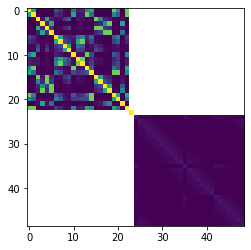

In [55]:
# build the prior covariance matrix and store it as a compresed bianry file (otherwise it can get huge!)
if pf.pst.npar < 35000:  #if you have more than about 35K pars, the cov matrix becomes hard to handle
    cov = pf.build_prior(fmt='coo', filename=os.path.join(template_ws,"prior_cov.jcb"))
    # and take a peek at a slice of the matrix
    try: 
        x = cov.x.copy()
        x[x==0] = np.NaN
        plt.imshow(x[-49:,-49:])
    except:
        pass

And now generate a prior parameter ensemble. This step is relevant for using pestpp-ies in subsequent tutorials.

In [56]:
pe = pf.draw(num_reals=100, use_specsim=True) # draw parameters from the prior distribution
pe.enforce() # enforces parameter bounds
pe.to_binary(os.path.join(template_ws,"prior_pe.jcb")) #writes the paramter ensemble to binary file

# final tidy-up
pst.pestpp_options["ies_parameter_ensemble"] = "prior_pe.jcb" #adds pest++ options to the control file
pst.write(os.path.join(template_ws, 'freyberg_mf6.pst')) # re-writes the control file with the new pest++ options

2022-03-18 15:12:36.130861 starting: drawing realizations
2022-03-18 15:12:36.285669 starting: spectral simulation for grid-scale pars


SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-18 15:12:36.511961 starting: SpecSim: drawing 100 realization for group npf_k_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-18 15:12:36.561879 finished: SpecSim: drawing 100 realization for group npf_k_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.049918
2022-03-18 15:12:36.565816 starting: SpecSim: drawing 100 realization for group npf_k_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)


SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-18 15:12:36.611746 finished: SpecSim: drawing 100 realization for group npf_k_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.045930
2022-03-18 15:12:36.615741 starting: SpecSim: drawing 100 realization for group npf_k_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-18 15:12:36.661613 finished: SpecSim: drawing 100 realization for group npf_k_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.045872
2022-03-18 15:12:36.665603 starting: SpecSim: drawing 100 realization for group npf_k33_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-18 15:12:36.711480 finished: SpecSim: drawing 100 realization for

2022-03-18 15:12:36.764344 starting: SpecSim: drawing 100 realization for group npf_k33_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-18 15:12:36.810164 finished: SpecSim: drawing 100 realization for group npf_k33_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.045820
2022-03-18 15:12:36.814153 starting: SpecSim: drawing 100 realization for group sto_ss_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-18 15:12:36.860062 finished: SpecSim: drawing 100 realization for group sto_ss_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.045909
2022-03-18 15:12:36.864019 starting: SpecSim: drawing 100 realization for group sto_ss_layer3_gr with 706 pars, (log) variance 0.0

2022-03-18 15:12:36.958767 finished: SpecSim: drawing 100 realization for group sto_sy_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.045845
2022-03-18 15:12:36.962791 starting: SpecSim: drawing 100 realization for group rch_recharge_1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-18 15:12:37.007686 finished: SpecSim: drawing 100 realization for group rch_recharge_1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.044895
2022-03-18 15:12:37.011625 starting: SpecSim: drawing 100 realization for group rch_recharge_10_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-18 15:12:37.057554 finished: SpecSim: drawing 100 realization for group rch_recharge_10_gr with 706 pars, (log) variance

2022-03-18 15:12:37.160272 starting: SpecSim: drawing 100 realization for group rch_recharge_13_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-18 15:12:37.206136 finished: SpecSim: drawing 100 realization for group rch_recharge_13_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.045864
2022-03-18 15:12:37.210103 starting: SpecSim: drawing 100 realization for group rch_recharge_14_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-18 15:12:37.256004 finished: SpecSim: drawing 100 realization for group rch_recharge_14_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.045901
2022-03-18 15:12:37.259961 starting: SpecSim: drawing 100 realization for group rch_recharge_15_gr with 706 pars, (log) vari

2022-03-18 15:12:37.359258 starting: SpecSim: drawing 100 realization for group rch_recharge_17_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-18 15:12:37.405167 finished: SpecSim: drawing 100 realization for group rch_recharge_17_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.045909
2022-03-18 15:12:37.409125 starting: SpecSim: drawing 100 realization for group rch_recharge_18_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-18 15:12:37.456998 finished: SpecSim: drawing 100 realization for group rch_recharge_18_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.047873
2022-03-18 15:12:37.460988 starting: SpecSim: drawing 100 realization for group rch_recharge_19_gr with 706 pars, (log) vari

2022-03-18 15:12:37.558752 finished: SpecSim: drawing 100 realization for group rch_recharge_2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.045904
2022-03-18 15:12:37.562748 starting: SpecSim: drawing 100 realization for group rch_recharge_20_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-18 15:12:37.608643 finished: SpecSim: drawing 100 realization for group rch_recharge_20_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.045895
2022-03-18 15:12:37.612634 starting: SpecSim: drawing 100 realization for group rch_recharge_21_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-18 15:12:37.657497 finished: SpecSim: drawing 100 realization for group rch_recharge_21_gr with 706 pars, (log) varia

2022-03-18 15:12:37.759248 finished: SpecSim: drawing 100 realization for group rch_recharge_23_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.047929
2022-03-18 15:12:37.762290 starting: SpecSim: drawing 100 realization for group rch_recharge_24_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-18 15:12:37.808160 finished: SpecSim: drawing 100 realization for group rch_recharge_24_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.045870
2022-03-18 15:12:37.812162 starting: SpecSim: drawing 100 realization for group rch_recharge_25_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-18 15:12:37.858033 finished: SpecSim: drawing 100 realization for group rch_recharge_25_gr with 706 pars, (log) vari

2022-03-18 15:12:37.957329 finished: SpecSim: drawing 100 realization for group rch_recharge_4_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.045456
2022-03-18 15:12:37.961348 starting: SpecSim: drawing 100 realization for group rch_recharge_5_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-18 15:12:38.007197 finished: SpecSim: drawing 100 realization for group rch_recharge_5_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.045849
2022-03-18 15:12:38.012184 starting: SpecSim: drawing 100 realization for group rch_recharge_6_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-18 15:12:38.058113 finished: SpecSim: drawing 100 realization for group rch_recharge_6_gr with 706 pars, (log) variance 

2022-03-18 15:12:38.200679 finished: SpecSim: drawing 100 realization for group rch_recharge_9_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.043882
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-18 15:12:38.396189 finished: spectral simulation for grid-scale pars took: 0:00:02.110520
2022-03-18 15:12:38.396189 starting: Drawing non-specsim pars
building diagonal cov


processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['npf_k_layer1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k_layer2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['npf_k_layer3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k33_layer1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k33_layer2_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k33_layer3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['sto_ss_layer2_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['sto_ss_layer3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['sto_sy_layer1_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_10_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_11_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_12_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_13_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_14_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_15_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_16_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_17_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_18_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_19_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_20_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_21_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_22_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_23_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_24_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_25_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_4_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_5_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_6_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_7_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_8_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_9_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['ghbcond_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbcond_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbcond_gr']


build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['sfrcond_gr']
build cov matrix
done
getting diag var cov 40
scaling full cov by diag var cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0

working on pargroups ['wel_cst']
build cov matrix


done
getting diag var cov 25
scaling full cov by diag var cov
working on pargroups ['sfr_gr']
build cov matrix
done
getting diag var cov 25
scaling full cov by diag var cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['ghbhead_gr']


build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbhead_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbhead_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov


adding remaining parameters to diagonal


2022-03-18 15:12:45.923305 finished: Drawing non-specsim pars took: 0:00:07.527116


2022-03-18 15:12:47.982565 finished: drawing realizations took: 0:00:11.851704


noptmax:0, npar_adj:25454, nnz_obs:920


### 9. Observation Uncertainty Covariance Matrix

Lastly, not so common, let's also generate our observation covariance matrix. Often this step is omitted, in particular if the observation weights in the `* observation data` section reflect observation uncertainty. Here we will implement it expressly so as to:

 - make life easier for the authors to organize the tutorial notebooks;
 - because we are going to be fiddlying around with the observation weights later on, and this  way we keep a "backup" of our observation uncertainty;
 - and to demonstrate how to add autocorrelated transient noise! When is the last time you saw that in the wild?

First let us start by generating a covariance matrix, using the weights recorded in the `pst.observation_data` section. This is accomplished with `pyemu.Cov.from_observation_data()`. This will generate a covariance matrix for **all** observations in the control file, even the zero-weighted ones. 

However, we are only interested in keep the non-zero weighted observations. We can use `pyemu` convenient Matrix manipulation functions to `.get()` the covariance matrix rows/columns that we are interested in.

In [57]:
obs = pst.observation_data

# generate cov matrix for all obs using weights in the control file
obs_cov = pyemu.Cov.from_observation_data(pst, )

# reduce cov down to only include non-zero obsverations
obs_cov = obs_cov.get(row_names=pst.nnz_obs_names, col_names=pst.nnz_obs_names, )

# side note: 
# going to save the diagonal (e.g no correlation) obsevration uncertainty cov matrixs
# to an external file for use in a later tutorial
obs_cov.to_coo(os.path.join(template_ws,"obs_cov_diag.jcb"))

# make it a dataframe to make life easier
df = obs_cov.to_dataframe()

df.head()

,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:245.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:275.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:306.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:32.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:336.0,...,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:183.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:214.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:245.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:275.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:306.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:32.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:336.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:367.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:61.0,oname:hdsvd_otype:lst_usecol:trgw_0_9_1_time:92.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,0.01,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,0.00,0.01,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,0.00,0.00,0.01,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,0.00,0.00,0.00,0.01,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,0.00,0.00,0.00,0.00,0.01,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


So this returned a diagonal covariance matrix (e.g. only values in the diagonal are non-zero). This implies that there is no covariance between observation noise. 

You can plot the matrix, but due to the scale it wont look particularily interesting:

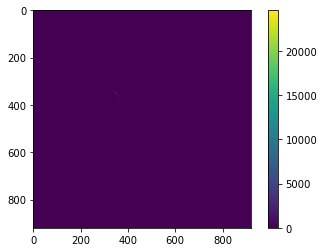

In [58]:
plt.imshow(df.values)
plt.colorbar()

Let's instead just look at a small part, focusing on observations that make up a single time series. So as you can see below, the matrix diagonal reflects individual obsevation uncertianties, whilst all the off-diagonals are zero (e.g. no correlation).

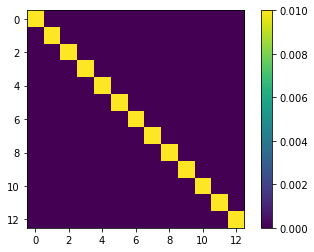

In [59]:
obs_select = obs.loc[(obs.obgnme=='oname:hds_otype:lst_usecol:trgw_0_13_10') & (obs.weight>0)]

plt.imshow(df.loc[obs_select.obsnme,obs_select.obsnme].values)
plt.colorbar()

But recall that most of the observations are time-series. Here we are saying "how wrong the measurement is today, has nothing to do with how wrong it was yesterday". Is that reasonable? For some noise (e.g. white noise), yes, surely. But perhaps not for all noise. So how can we express that "if my measurement was wrong yesterday, then it is *likely* to be wrong in the same way today"? Through covariance, that's how. We can use the same priciples that we employed to specfy parameter spatial/temporal covariance earlier on.

We will no demonstrate for the single time series we looked at above. 

First, construct a geostatistical structure and variogram. Here we are using a range of 60 days. (Recall we have "field measurements" every month.) From these, construct a generic covariance matrix for generic parameters with "coordinates" corresponding to the observation times. 

In [60]:
v = pyemu.geostats.ExpVario(a=30,contribution=1.0)
x = obs_select.time.astype(float).values #np.arange(float(obs.time.values[:11].max()))
y = np.zeros_like(x)
names = ["obs_{0}".format(xx) for xx in x]
cov = v.covariance_matrix(x,y,names=names)

Then, scale the values in the generic covariance matrix to reflect the observation uncertainties and take a peek.

And there you have it, off-diagonal elements are no longer zero and show greater correlation between uncertainties of observation which happen closer together (it looks a bit wonky because parameter names are not ordered acording to time).

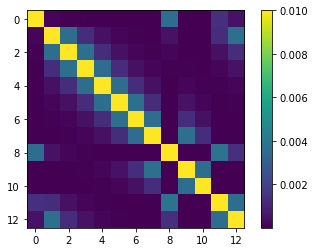

In [61]:
x_group = cov.x.copy()
w = obs_select.weight.mean()
v = (1./w)**2
x_group *= v
df.loc[obs_select.obsnme,obs_select.obsnme] = x_group

plt.imshow(df.loc[obs_select.obsnme,obs_select.obsnme].values);
plt.colorbar();

Now implement to that to loop over all the non-zero time series observation groups:

In [62]:
for obgnme in pst.nnz_obs_groups:
    obs_select = obs.loc[(obs.obgnme==obgnme) & (obs.weight>0)]

    v = pyemu.geostats.ExpVario(a=30,contribution=1.0)
    x = obs_select.time.astype(float).values #np.arange(float(obs.time.values[:11].max()))
    y = np.zeros_like(x)
    names = ["obs_{0}".format(xx) for xx in x]
    cov = v.covariance_matrix(x,y,names=names)


    x_group = cov.x.copy()
    w = obs_select.weight.mean()
    v = (1./w)**2
    x_group *= v
    df.loc[obs_select.obsnme,obs_select.obsnme] = x_group


And then re-construct a `Cov` object and record it to an external file:

In [63]:
obs_cov_tv = pyemu.Cov.from_dataframe(df)
obs_cov_tv.to_coo(os.path.join(template_ws,"obs_cov.jcb"))